<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/.shortcut-targets-by-id/1FKl2J9VPA88stIpA_grTLED-Fv9_B7CF/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

logs/  orderparams.ipynb  problems.txt  __pycache__/  test.png


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 7.2MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=f98ec87b2614ab4545aaf13add9be8e858824a8f798ac2cbe324cf67cf588eb9
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 7.5MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" code.

In [ ]:
class OrderMethods():

    def getData(T, x, p):
        Jt, Nf, Bk = p
        return OrderMethods.orderparameter(T, x, Jt, Nf, Bk)

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        #print t
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        nllfs = []
        zin = []
        for tns in np.arange(50,200, 5):
            #print("zs", zs)
            model.Tn.value = tns
            model.update()
            schi=model.nllf()
            nllfs.append(schi)
            zin.append(tns)
        plt.scatter(zin, nllfs)
        plt.xlabel("tn in")
        plt.ylabel("chi") 
        plt.show()
        plt.savefig("chisurface")
        plt.close()
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [ ]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env): #add gym.env

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.startTn = 150
        self.p = [.885,330,.3]
        self.error = []
        # self.M = Curve(orderparameter, T, I, error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
        # self.M.Tn.range(self.startTn - 20 , self.startTn + 20)

        # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Box(0, 337)
        self.curTemp = 3
        self.x = self.startTn

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 

        print("stepping: ", self.episodeNum)
        print("delta T: ", action)

        self.curTemp += action
        self.curTemp = self.round_to(self.curTemp, 0.5)
        print("curtemp: ", self.curTemp)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 1:
            self.I = OrderMethods.getData(self.T, self.x, self.p)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
            M.Tn.range(self.x - 20 , self.x + 20)

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.x = self.x[0]
            print("THE RESULT:", self.x)

            dx = params[0].dx

            print("chisqds: ", chisq)
            print("BUT ARE WE SURE?:", dx)

            # if(action > 0.5):
            #   reward += 1000

            if chisq < 2 and dx < 2:
                  reward += 100 + 1/dx

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)

        print("highHIIIIGHHHHHH: ", (340-self.curTemp))
        print("rewaRD:: ", reward)

        self.totReward += reward
        np.append(self.state, self.curTemp)
        delta = abs(340 - self.curTemp)


        if (self.steps > 20 and chisq < 0.05 and dx < 2): #less than or equal to?
            print("terminated: excellent conditions")
            terminal = True
            self.log()
        elif (self.steps > 100):
            print("terminated: too long")
            terminal = True
            self.log()
        else:
            terminal = False

        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([self.curTemp])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.transTemps)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.txt"
        np.savetxt(filename, self.rewards)

    @property
    def action_space(self):
        #return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
        return spaces.Box(low = np.array(self.curTemp)

    @property 
    def observation_space(self):
        return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)


    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision


reset
stepping:  0
delta T:  [22.064482]
curtemp:  25.0
Temperature:  [25.]
highHIIIIGHHHHHH:  315.0
rewaRD::  -100
stepping:  0
delta T:  [301.23596]
curtemp:  326.0
Temperature:  [ 25. 326.]
Intensity:  [3.30246809e+02 3.00000000e-01]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


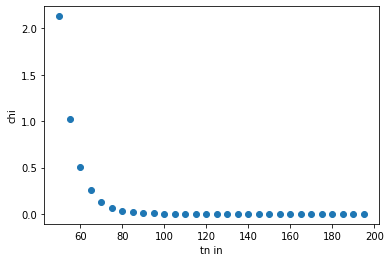

THE RESULT: 149.99999999961895
chisqds:  5.635652876130551e-27
BUT ARE WE SURE?: 5365.436907331329
highHIIIIGHHHHHH:  14.0
rewaRD::  -100
stepping:  0
delta T:  [2.4911451]
curtemp:  328.5
Temperature:  [ 25.  326.  328.5]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01]


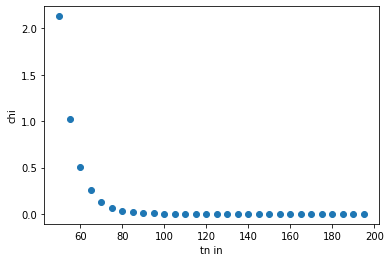

THE RESULT: 149.99999999924017
chisqds:  2.1573983666437356e-27
BUT ARE WE SURE?: 5365.436895311452
highHIIIIGHHHHHH:  11.5
rewaRD::  -100
stepping:  0
delta T:  [6.352968]
curtemp:  335.0
Temperature:  [ 25.  326.  328.5 335. ]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01]


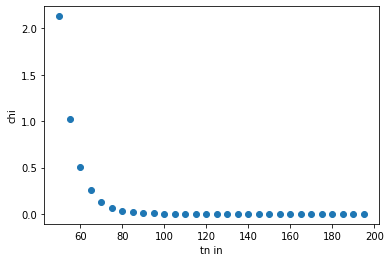

THE RESULT: 149.99999999887453
chisqds:  1.5785046250273193e-27
BUT ARE WE SURE?: 5365.436901301522
highHIIIIGHHHHHH:  5.0
rewaRD::  -100
stepping:  0
delta T:  [4.068082]
curtemp:  339.0
Temperature:  [ 25.  326.  328.5 335.  339. ]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]


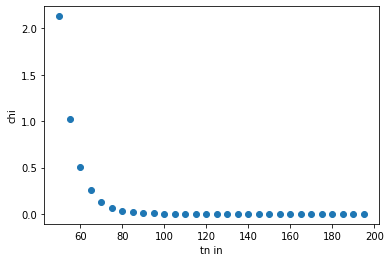

THE RESULT: 149.99999999850547
chisqds:  1.1838784687704938e-27
BUT ARE WE SURE?: 5365.43690128891
highHIIIIGHHHHHH:  1.0
rewaRD::  -100
stepping:  0
delta T:  [0.5001256]
curtemp:  339.5
Temperature:  [ 25.  326.  328.5 335.  339.  339.5]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]


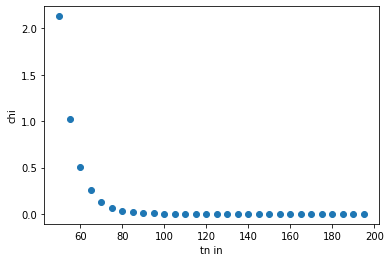

THE RESULT: 149.99999999815174
chisqds:  9.471027750163984e-28
BUT ARE WE SURE?: 5365.436901276249
highHIIIIGHHHHHH:  0.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  340.0
Temperature:  [ 25.  326.  328.5 335.  339.  339.5 340. ]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]


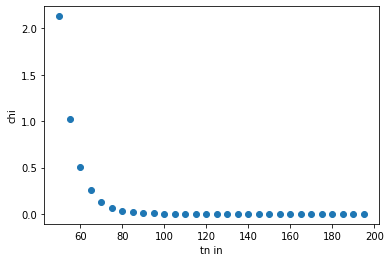

THE RESULT: 149.99999999777611
chisqds:  7.892523125136686e-28
BUT ARE WE SURE?: 5365.436907266561
highHIIIIGHHHHHH:  0.0
rewaRD::  -100
stepping:  0
delta T:  [0.18881291]
curtemp:  340.0
Temperature:  [ 25.  326.  328.5 335.  339.  339.5 340.  340. ]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]


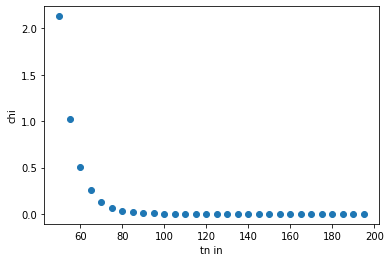

THE RESULT: 149.99999999740228
chisqds:  6.7650198215457555e-28
BUT ARE WE SURE?: 5365.43690124942
highHIIIIGHHHHHH:  0.0
rewaRD::  -100
stepping:  0
delta T:  [0.2027164]
curtemp:  340.0
Temperature:  [ 25.  326.  328.5 335.  339.  339.5 340.  340.  340. ]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]


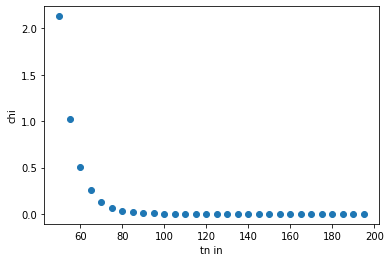

THE RESULT: 149.99999999704218
chisqds:  5.9193923438525605e-28
BUT ARE WE SURE?: 5365.43689523337
highHIIIIGHHHHHH:  0.0
rewaRD::  -100
stepping:  0
delta T:  [0.26560062]
curtemp:  340.5
Temperature:  [ 25.  326.  328.5 335.  339.  339.5 340.  340.  340.  340.5]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]


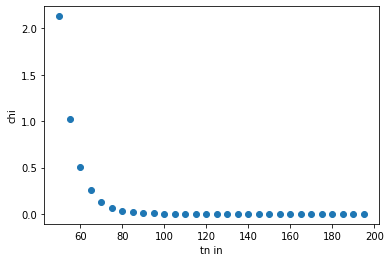

THE RESULT: 149.99999999667594
chisqds:  4.79421859254176e-28
BUT ARE WE SURE?: 5365.43689522026
highHIIIIGHHHHHH:  -0.5
rewaRD::  -100
stepping:  0
delta T:  [0.3552172]
curtemp:  341.0
Temperature:  [ 25.  326.  328.5 335.  339.  339.5 340.  340.  340.  340.5 341. ]
Intensity:  [3.30246809e+02 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]


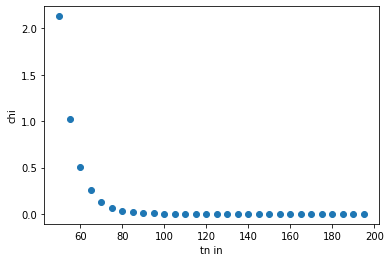

THE RESULT: 149.9999999963175
chisqds:  4.735513875082082e-28
BUT ARE WE SURE?: 5365.436889204872
highHIIIIGHHHHHH:  -1.0
rewaRD::  -100
Box(1,)
(1,)
True
[-1.]
[0.5]
Box(12,)
(12,)


In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)
a = env.action_space
o = env.observation_space
print(a)                    #prints Box(1,)
print(a.shape)              #prints (1,), note that you can do a.shape[0] which is 1 here
print(a.is_bounded())       #prints True if your action space is bounded
print(a.high)               #prints [1.] an array with the maximum value for each dim
print(a.low)                #prints [-1.] same for minimum value
print(o)
print(o.shape)

In [ ]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reset
stepping:  0
delta T:  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  0
delta T:  [1.2308778]
curtemp:  4.5
Temperature:  [3.5 4.5]
Intensity:  [330.3 330.3]


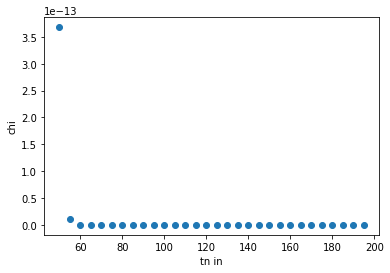

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.5 5. ]
Intensity:  [330.3 330.3 330.3]


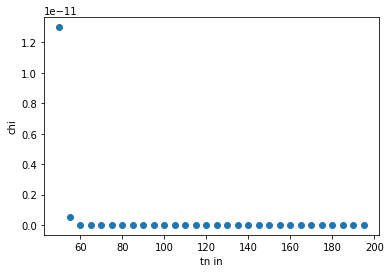

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.5 5.  5.5]
Intensity:  [330.3 330.3 330.3 330.3]


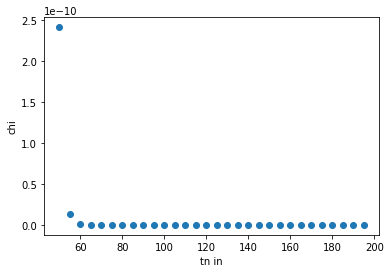

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.5 5.  5.5 6. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3]


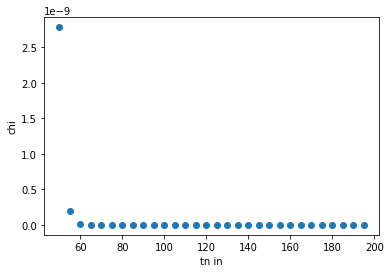

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.0
rewaRD::  -100
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 5         |
| nupdates           | 1         |
| policy_entropy     | 1.42      |
| total_timesteps    | 5         |
| value_loss         | 1.07e+05  |
----------------------------------
stepping:  0
delta T:  [0.5]
curtemp:  6.5
Temperature:  [3.5 4.5 5.  5.5 6.  6.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3]


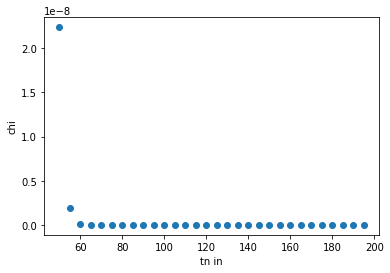

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  333.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  7.0
Temperature:  [3.5 4.5 5.  5.5 6.  6.5 7. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3]


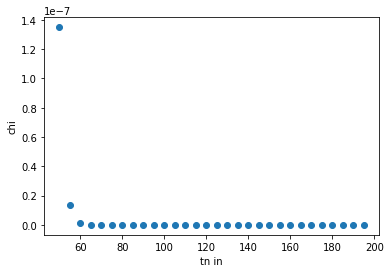

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  7.5
Temperature:  [3.5 4.5 5.  5.5 6.  6.5 7.  7.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


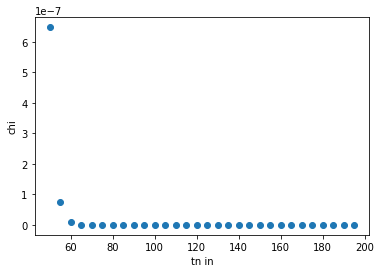

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  0
delta T:  [2.2531035]
curtemp:  10.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


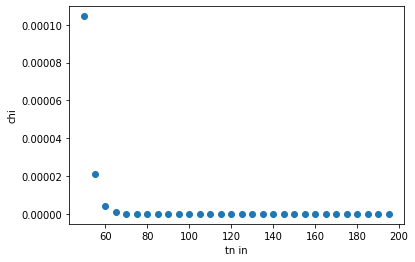

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.151
highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


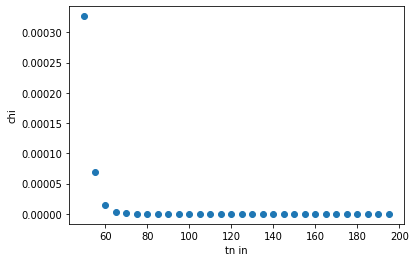

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1222705972067.848
highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  0
delta T:  [1.4210918]
curtemp:  12.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


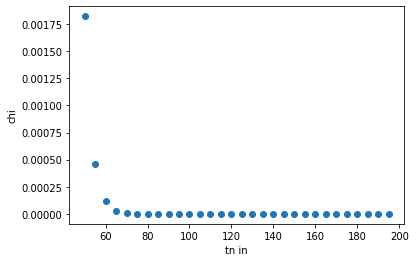

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 31162881763.282623
highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999]


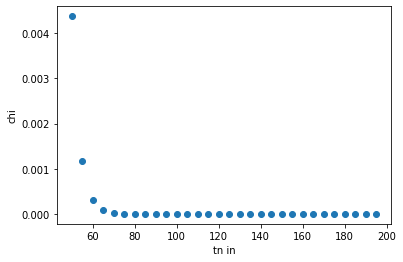

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 10915227242.665545
highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  0
delta T:  [2.0311303]
curtemp:  14.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962]


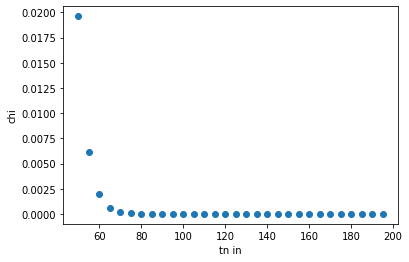

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 438301074.0888237
highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  0
delta T:  [2.3631568]
curtemp:  17.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912 ]


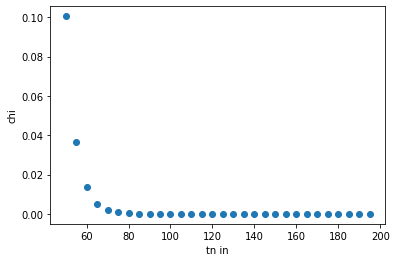

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 22061403.72282182
highHIIIIGHHHHHH:  323.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  17.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518]


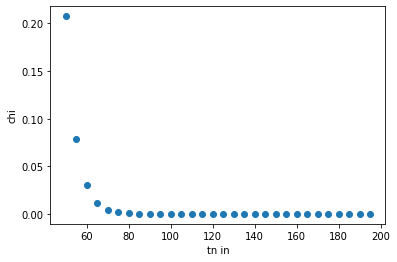

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 11513307.285449697
highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  0
delta T:  [2.093464]
curtemp:  19.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864]


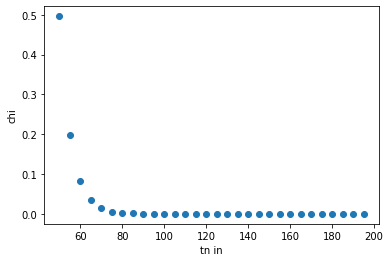

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2386355.4959083092
highHIIIIGHHHHHH:  320.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  20.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864  ]


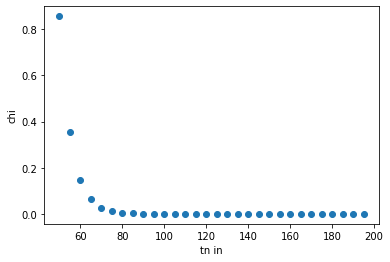

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1374040.384211956
highHIIIIGHHHHHH:  320.0
rewaRD::  -100
stepping:  0
delta T:  [1.0516677]
curtemp:  21.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525]


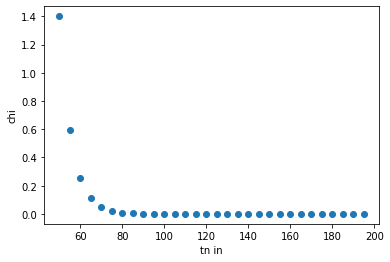

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 718420.225673375
highHIIIIGHHHHHH:  319.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  21.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847]


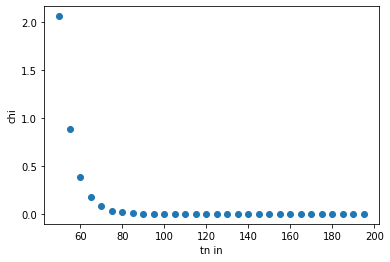

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 465828.53641954856
highHIIIIGHHHHHH:  318.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  22.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256]


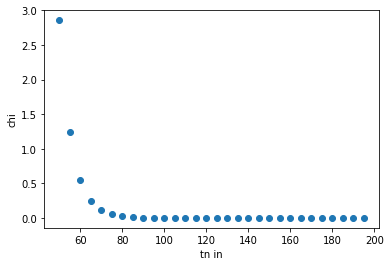

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 324019.38036293816
highHIIIIGHHHHHH:  318.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  22.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733]


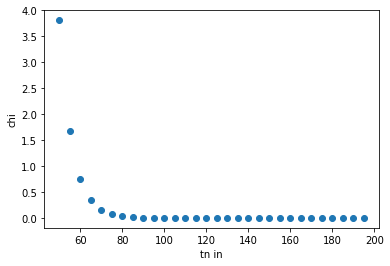

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 233609.32708493466
highHIIIIGHHHHHH:  317.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  23.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065]


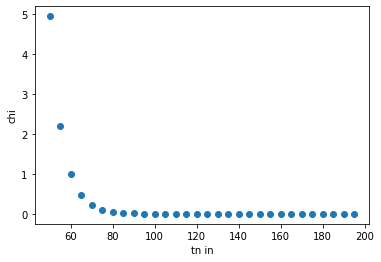

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 172353.09690747302
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  0
delta T:  [1.0992751]
curtemp:  24.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391]


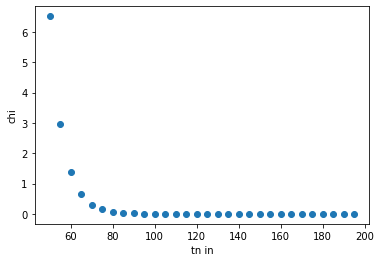

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 113932.06258120481
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  24.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845]


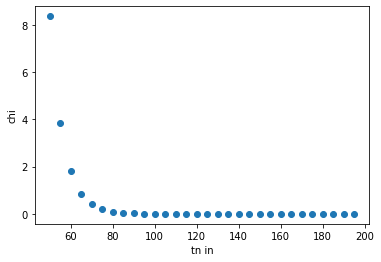

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 82310.38534178106
highHIIIIGHHHHHH:  315.5
rewaRD::  -100
stepping:  0
delta T:  [1.0511252]
curtemp:  25.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543]


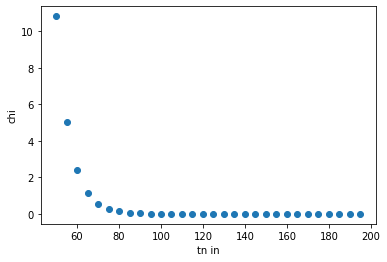

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 55594.757441806796
highHIIIIGHHHHHH:  314.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  26.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624]


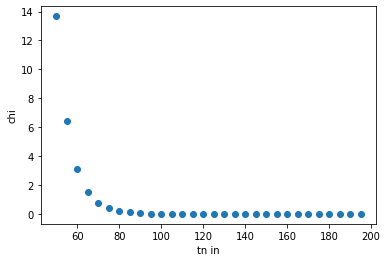

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 41036.191844078894
highHIIIIGHHHHHH:  314.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  26.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253]


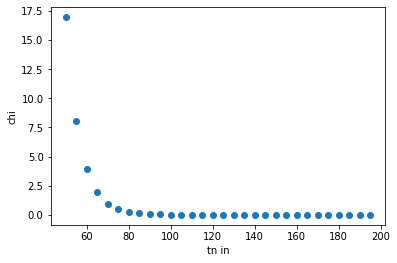

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 31589.469007136566
highHIIIIGHHHHHH:  313.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  27.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077]


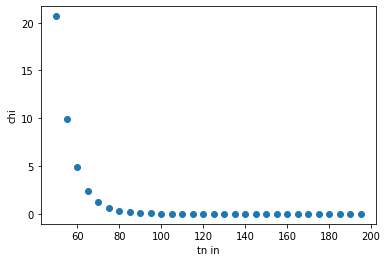

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 24929.635186300377
highHIIIIGHHHHHH:  313.0
rewaRD::  -100
stepping:  0
delta T:  [1.5043051]
curtemp:  28.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304]


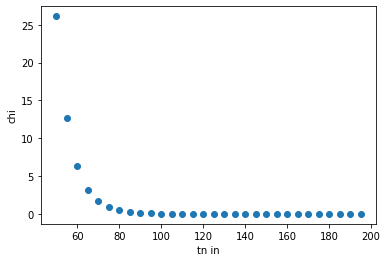

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 17058.570177344634
highHIIIIGHHHHHH:  311.5
rewaRD::  -100
stepping:  0
delta T:  [2.107242]
curtemp:  30.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192]


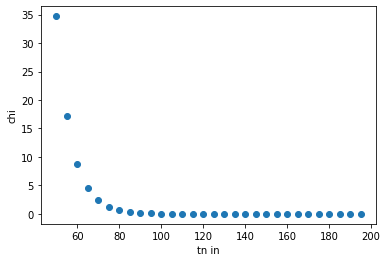

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 9951.458718925553
highHIIIIGHHHHHH:  309.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  31.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928]


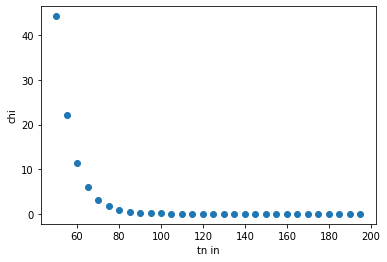

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 7244.493556389469
highHIIIIGHHHHHH:  309.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  31.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263 ]


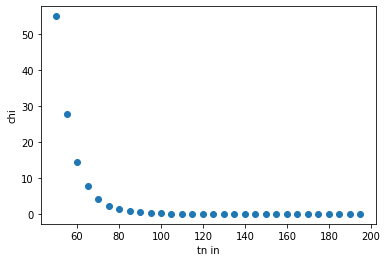

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 5681.712513136408
highHIIIIGHHHHHH:  308.5
rewaRD::  -100
stepping:  0
delta T:  [0.69019705]
curtemp:  32.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614]


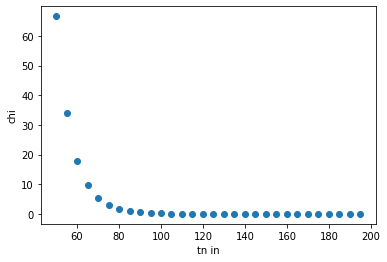

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4627.340095865805
highHIIIIGHHHHHH:  308.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  32.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887]


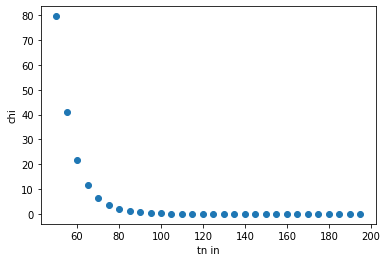

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3855.963016672513
highHIIIIGHHHHHH:  307.5
rewaRD::  -100
stepping:  0
delta T:  [0.96652347]
curtemp:  33.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861]


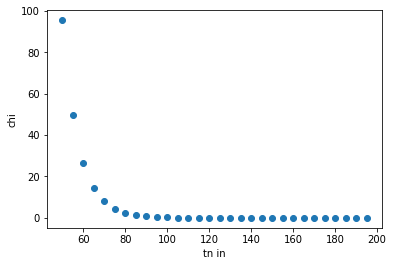

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3138.813031017426
highHIIIIGHHHHHH:  306.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  34.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141]


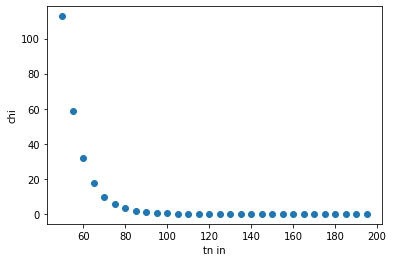

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2624.4860155180213
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  34.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429  ]


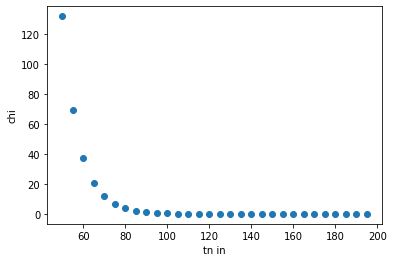

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2233.3457690123355
highHIIIIGHHHHHH:  305.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  35.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792]


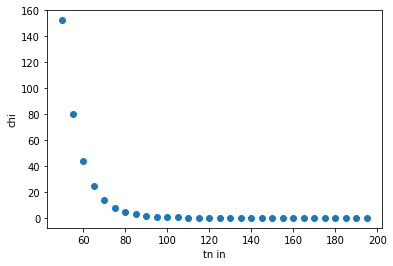

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1924.4326778325612
highHIIIIGHHHHHH:  305.0
rewaRD::  -100
stepping:  0
delta T:  [1.3381526]
curtemp:  36.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529]


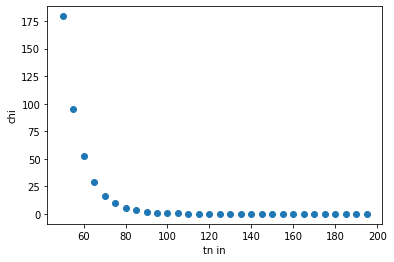

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1575.5703952419574
highHIIIIGHHHHHH:  303.5
rewaRD::  -100
stepping:  0
delta T:  [0.7574923]
curtemp:  37.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276]


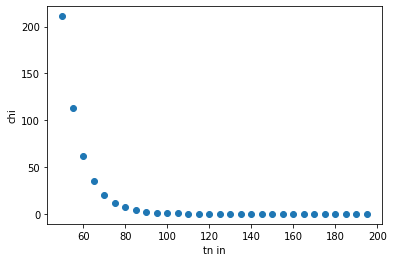

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1289.688135201331
highHIIIIGHHHHHH:  302.5
rewaRD::  -100
stepping:  0
delta T:  [1.1100824]
curtemp:  38.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463]


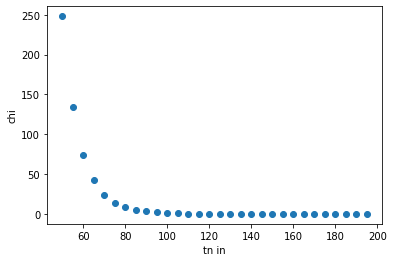

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1059.3229233994339
highHIIIIGHHHHHH:  301.5
rewaRD::  -100
stepping:  0
delta T:  [1.1659825]
curtemp:  39.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048]


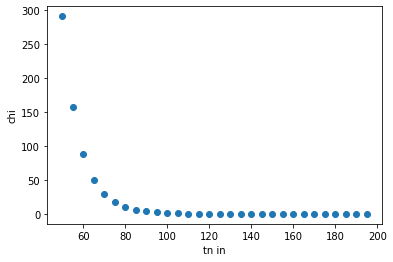

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 874.9138884812934
highHIIIIGHHHHHH:  300.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  40.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743]


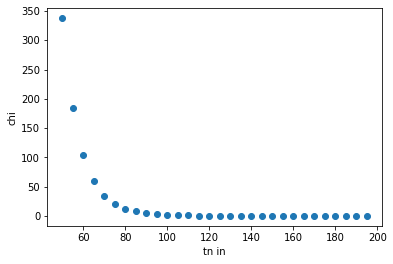

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 745.3883316468665
highHIIIIGHHHHHH:  300.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  40.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005  ]


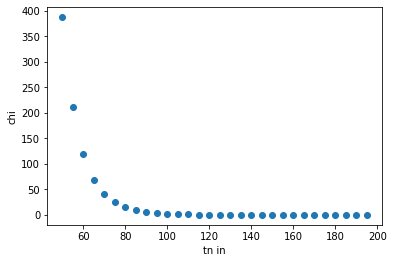

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 647.7068511924018
highHIIIIGHHHHHH:  299.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  41.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005   329.91338354]


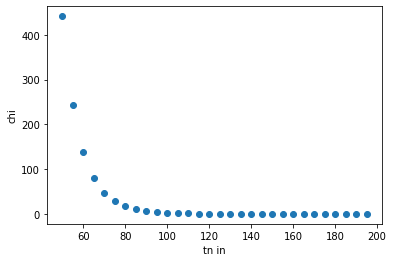

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 570.6006642202182
highHIIIIGHHHHHH:  299.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  41.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005   329.91338354
 329.8763

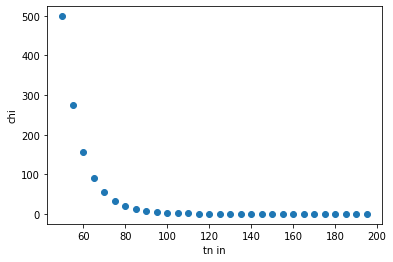

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 507.7886227826076
highHIIIIGHHHHHH:  298.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  42.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005   329.91338354
 329

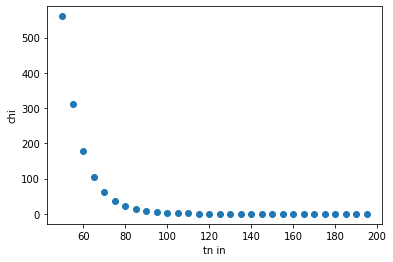

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 455.43772166644965
highHIIIIGHHHHHH:  298.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  42.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005   329.9133835

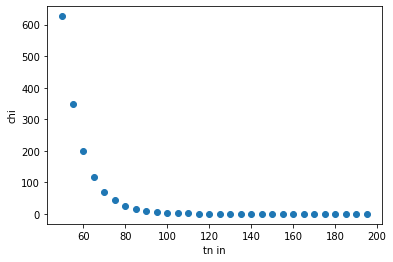

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 411.04711983533946
highHIIIIGHHHHHH:  297.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  43.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005   329.91

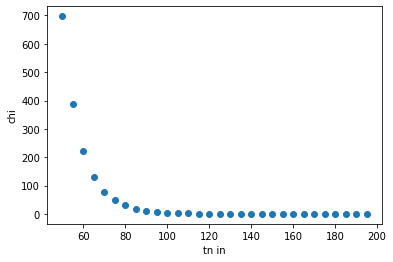

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 372.8988270100715
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  0
delta T:  [1.396064]
curtemp:  44.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005

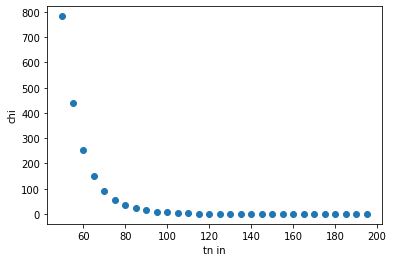

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 330.8326486978389
highHIIIIGHHHHHH:  295.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  45.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.948005

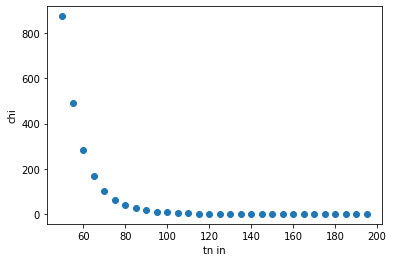

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 296.66369371026593
highHIIIIGHHHHHH:  295.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  45.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743 329.

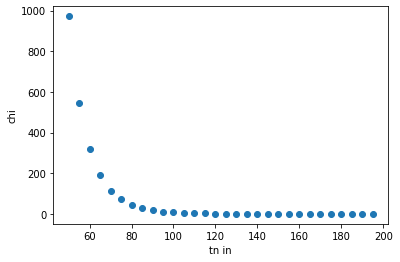

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 268.20366709346416
highHIIIIGHHHHHH:  294.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  46.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 329.98026743

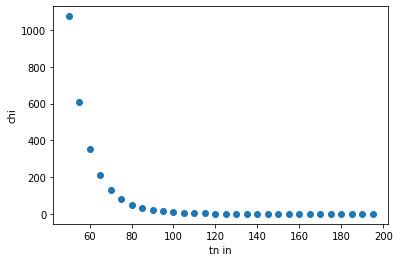

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 244.0458584892984
highHIIIIGHHHHHH:  294.0
rewaRD::  -100
stepping:  0
delta T:  [0.8926067]
curtemp:  47.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 32

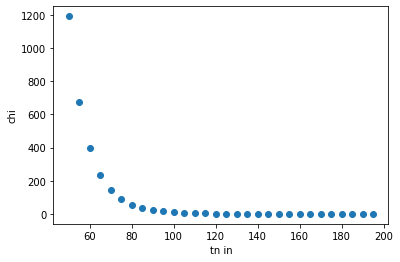

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 220.88453914482085
highHIIIIGHHHHHH:  293.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  47.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01027048 32

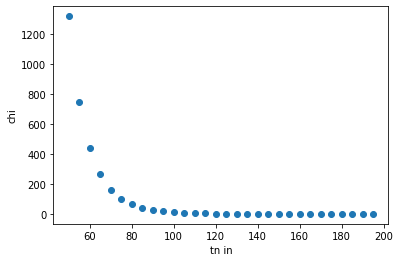

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 201.306613911522
highHIIIIGHHHHHH:  292.5
rewaRD::  -100
stepping:  0
delta T:  [0.8569028]
curtemp:  48.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.01

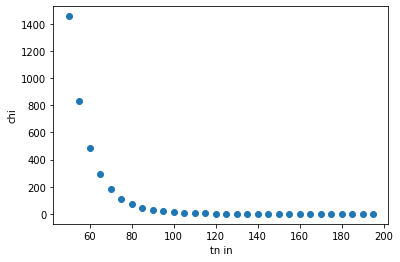

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 182.70721205523543
highHIIIIGHHHHHH:  291.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  49.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 330.

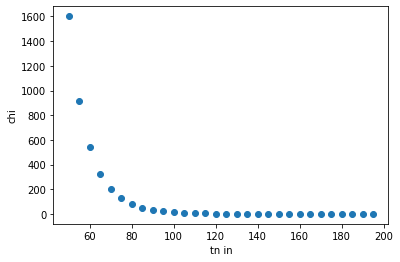

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 166.9724297450794
highHIIIIGHHHHHH:  291.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  49.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.06389463 

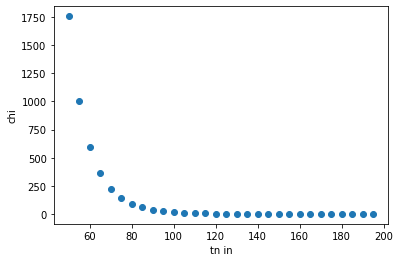

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 153.44238232258692
highHIIIIGHHHHHH:  290.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  50.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 330.063

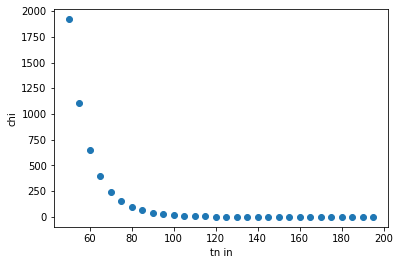

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 141.65672844273732
highHIIIIGHHHHHH:  290.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  50.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276
 33

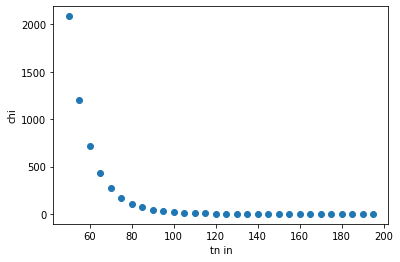

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 131.2824485560922
highHIIIIGHHHHHH:  289.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  51.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 330.10966276

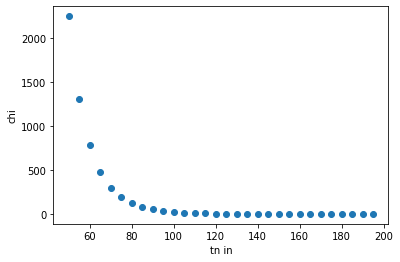

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 122.07129893266942
highHIIIIGHHHHHH:  289.0
rewaRD::  -100
stepping:  0
delta T:  [1.3914968]
curtemp:  52.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 

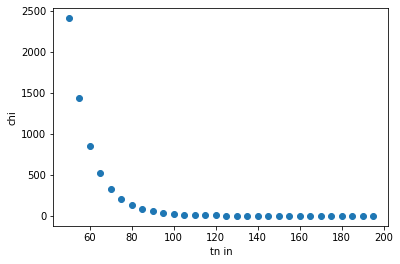

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 112.23784867348918
highHIIIIGHHHHHH:  287.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  53.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.14834529 3

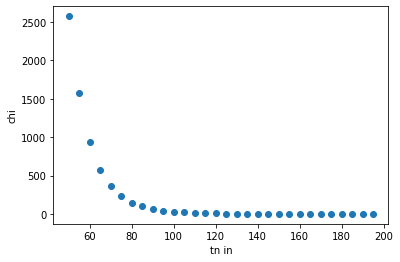

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 103.7517183939643
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  53.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792 330.148345

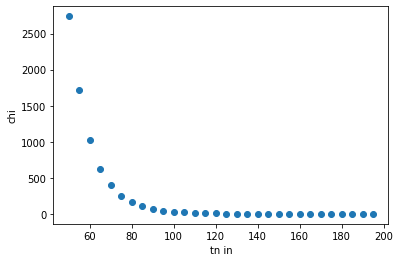

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 96.33339433839886
highHIIIIGHHHHHH:  286.5
rewaRD::  -100
stepping:  0
delta T:  [1.5823735]
curtemp:  55.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.19471792

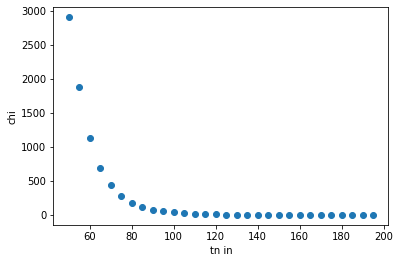

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 88.63342357626108
highHIIIIGHHHHHH:  285.0
rewaRD::  -100
stepping:  0
delta T:  [1.0725986]
curtemp:  56.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.194

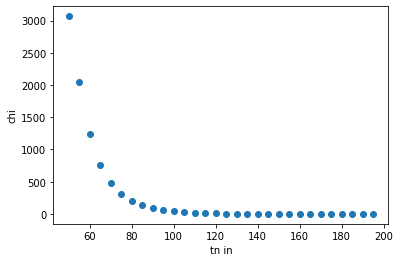

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 81.49993923584371
highHIIIIGHHHHHH:  284.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  56.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330.1947

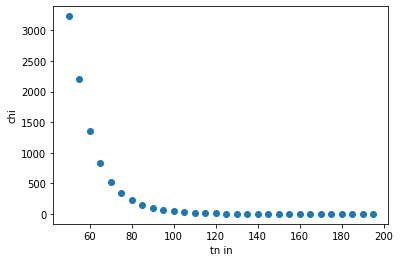

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 75.40527388369077
highHIIIIGHHHHHH:  283.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  57.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.207429   330

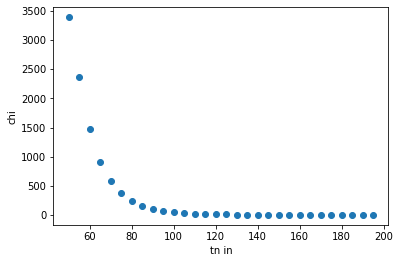

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 70.11774677017391
highHIIIIGHHHHHH:  283.0
rewaRD::  -100
stepping:  0
delta T:  [0.9178199]
curtemp:  58.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.2

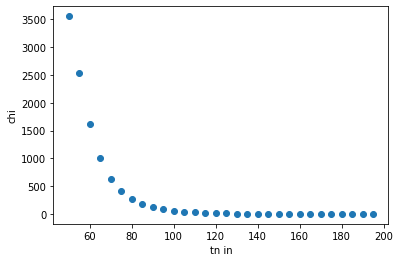

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 65.12385816018727
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  58.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.21891141 330.20

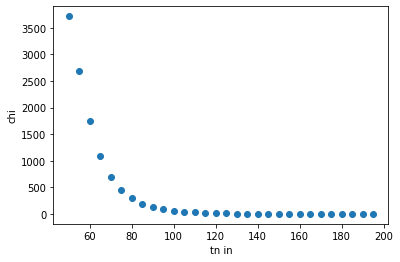

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 60.76221957678107
highHIIIIGHHHHHH:  281.5
rewaRD::  -100
stepping:  0
delta T:  [1.4191339]
curtemp:  60.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.218

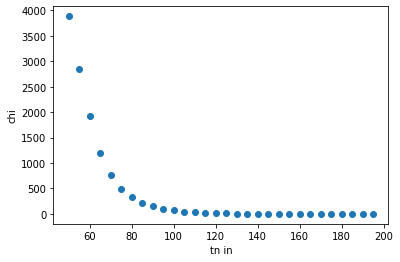

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 56.34307615380234
highHIIIIGHHHHHH:  280.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  60.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 330.2189

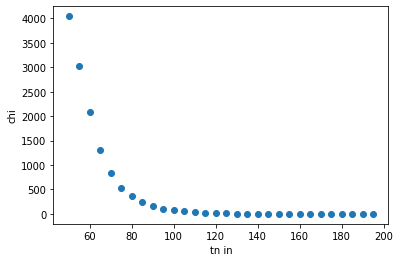

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 52.517530681286786
highHIIIIGHHHHHH:  279.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  61.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861
 33

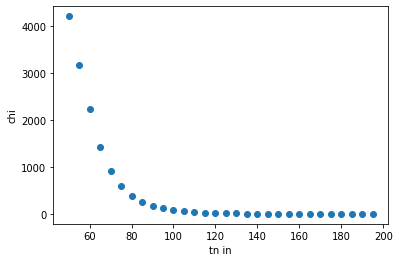

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 49.16233207653451
highHIIIIGHHHHHH:  279.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  61.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 330.22924861

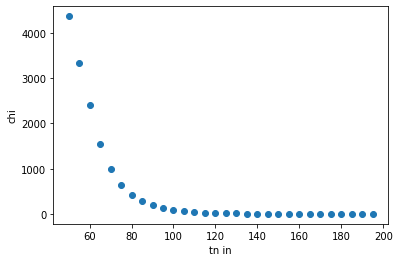

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 46.187954941011384
highHIIIIGHHHHHH:  278.5
rewaRD::  -100
stepping:  0
delta T:  [0.7521348]
curtemp:  62.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 

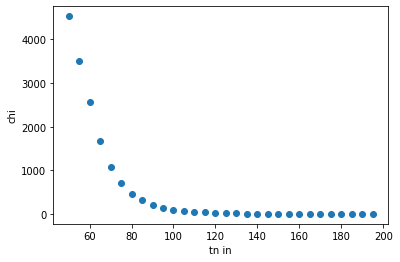

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 43.35216710293122
highHIIIIGHHHHHH:  277.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  63.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.24680887 33

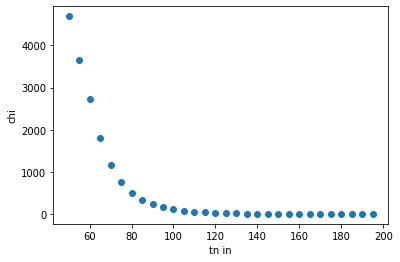

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 40.82721269545082
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  63.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.246808

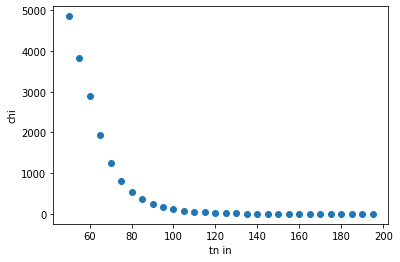

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 38.56021202678765
highHIIIIGHHHHHH:  276.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  64.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 330.2

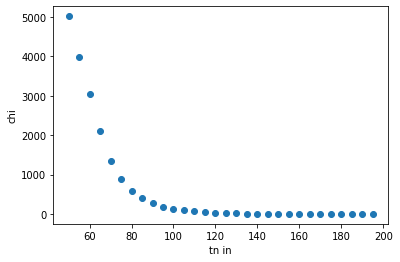

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 36.51034530141651
highHIIIIGHHHHHH:  276.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  64.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.25418614 

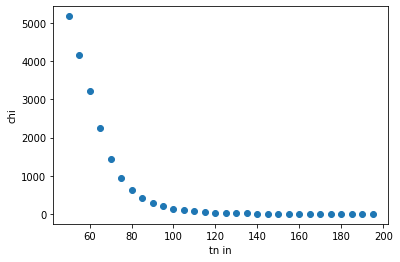

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 34.64550021179472
highHIIIIGHHHHHH:  275.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  65.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  330.2541

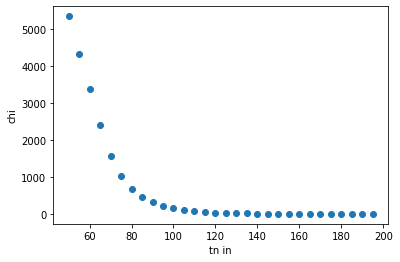

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 32.939995923419175
highHIIIIGHHHHHH:  275.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  65.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.2607263  33

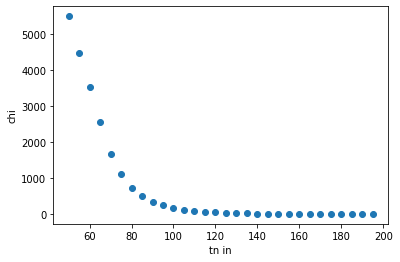

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 31.372996970674677
highHIIIIGHHHHHH:  274.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  66.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928 330.260726

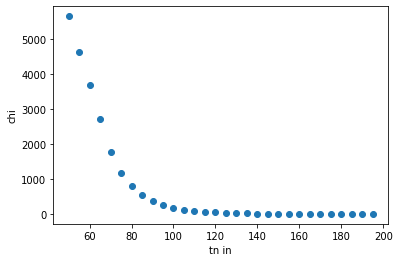

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 29.927382443983873
highHIIIIGHHHHHH:  274.0
rewaRD::  -100
stepping:  0
delta T:  [1.4472378]
curtemp:  67.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.26649928

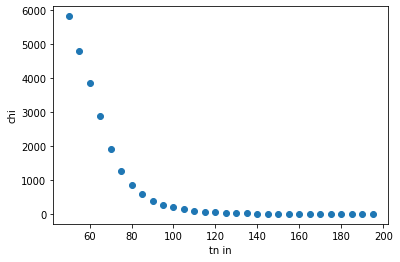

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 28.427797511511326
highHIIIIGHHHHHH:  272.5
rewaRD::  -100
stepping:  0
delta T:  [1.6715326]
curtemp:  69.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 330.266

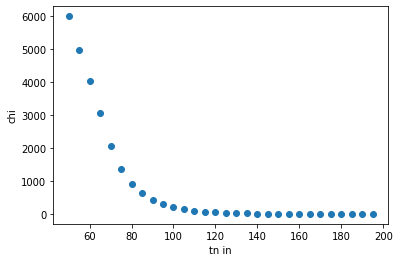

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 26.901817104100775
highHIIIIGHHHHHH:  271.0
rewaRD::  -100
stepping:  0
delta T:  [1.4507558]
curtemp:  70.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192
 33

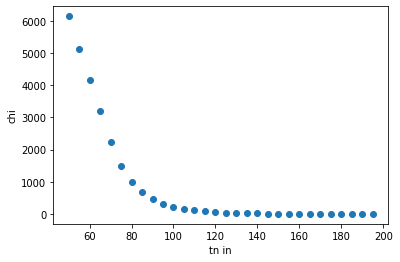

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 25.375445120486614
highHIIIIGHHHHHH:  269.5
rewaRD::  -100
stepping:  0
delta T:  [0.8224946]
curtemp:  71.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.2715719

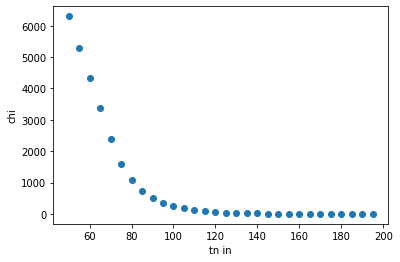

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 23.944253331998585
highHIIIIGHHHHHH:  268.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  72.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330.27157192

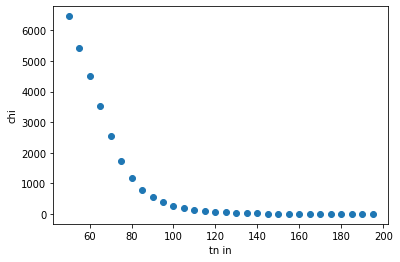

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 22.66853833248597
highHIIIIGHHHHHH:  268.0
rewaRD::  -100
stepping:  0
delta T:  [0.52526057]
curtemp:  72.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 3

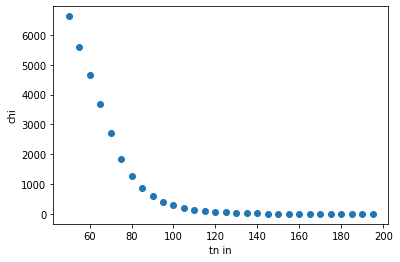

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 21.52164465010271
highHIIIIGHHHHHH:  267.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  73.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.28608304 330

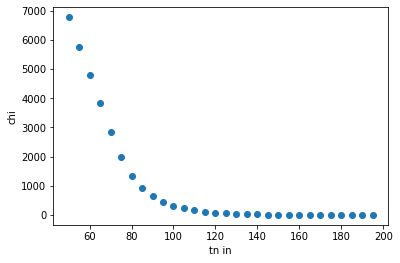

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 20.48301290447034
highHIIIIGHHHHHH:  267.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  73.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.2860830

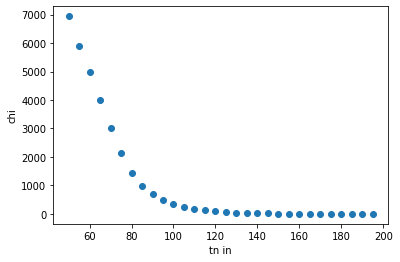

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 19.536486471482565
highHIIIIGHHHHHH:  266.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  74.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240077 330.2

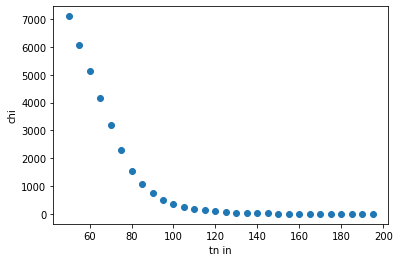

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 18.66916086828798
highHIIIIGHHHHHH:  266.0
rewaRD::  -100
stepping:  0
delta T:  [1.510216]
curtemp:  75.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240

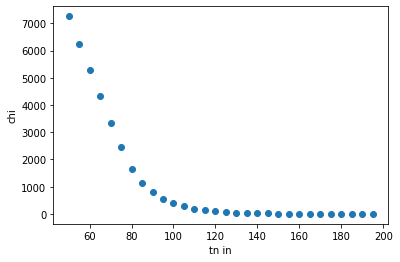

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 17.79202601680868
highHIIIIGHHHHHH:  264.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  76.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.29240

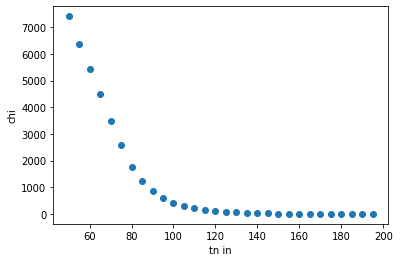

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 16.99180327504591
highHIIIIGHHHHHH:  264.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  76.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253 330.

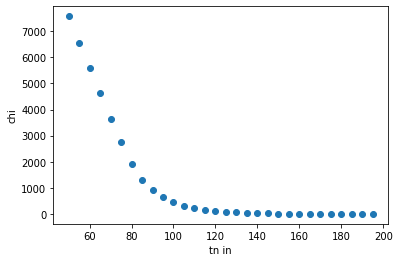

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 16.25778952245554
highHIIIIGHHHHHH:  263.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  77.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 330.29388253

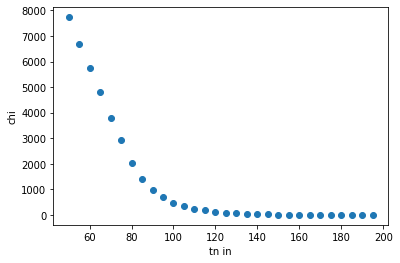

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 15.581298843797807
highHIIIIGHHHHHH:  263.0
rewaRD::  -100
stepping:  0
delta T:  [1.307089]
curtemp:  78.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77.  78.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 3

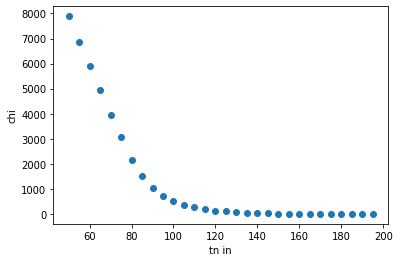

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 14.89735101459046
highHIIIIGHHHHHH:  261.5
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  79.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77.  78.5 79. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.29511624 33

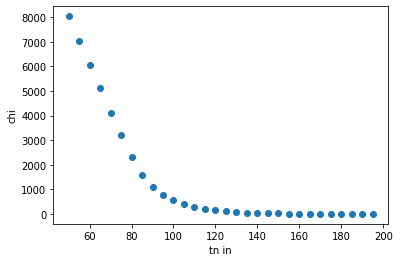

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 14.269482765407284
highHIIIIGHHHHHH:  261.0
rewaRD::  -100
stepping:  0
delta T:  [1.1242087]
curtemp:  80.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77.  78.5 79.  80. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330

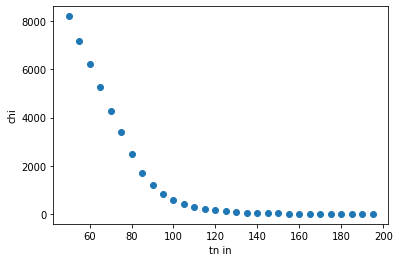

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 13.665061902760675
highHIIIIGHHHHHH:  260.0
rewaRD::  -100
stepping:  0
delta T:  [0.5]
curtemp:  80.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77.  78.5 79.  80.
 80.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.29613543
 330.

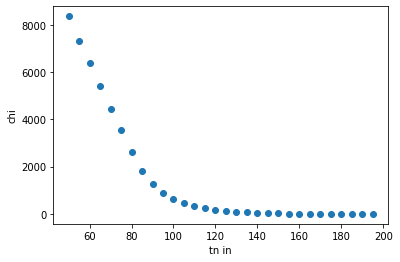

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 13.108391711756479
highHIIIIGHHHHHH:  259.5
rewaRD::  -100
stepping:  0
delta T:  [2.2128007]
curtemp:  82.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77.  78.5 79.  80.
 80.5 82.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 330.296

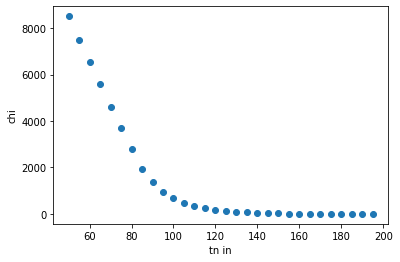

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 12.525984178986567
highHIIIIGHHHHHH:  257.5
rewaRD::  -100
stepping:  0
delta T:  [1.2860247]
curtemp:  84.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   6.5  7.   7.5 10.  10.5 12.  12.5 14.5 17.
 17.5 19.5 20.  21.  21.5 22.  22.5 23.  24.  24.5 25.5 26.  26.5 27.
 28.5 30.5 31.  31.5 32.  32.5 33.5 34.  34.5 35.  36.5 37.5 38.5 39.5
 40.  40.5 41.  41.5 42.  42.5 43.  44.5 45.  45.5 46.  47.  47.5 48.5
 49.  49.5 50.  50.5 51.  52.5 53.  53.5 55.  56.  56.5 57.  58.  58.5
 60.  60.5 61.  61.5 62.5 63.  63.5 64.  64.5 65.  65.5 66.  67.5 69.
 70.5 71.5 72.  72.5 73.  73.5 74.  75.5 76.  76.5 77.  78.5 79.  80.
 80.5 82.5 84. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.29999999 330.29999962 330.2999912  330.29998518
 330.29990864 330.299864   330.29971525 330.29959847 330.29944256
 330.29923733 330.29897065 330.29819391 330.29764845 33

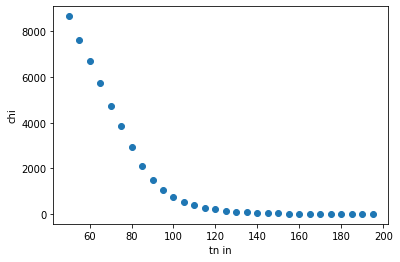

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 11.950059353981299
highHIIIIGHHHHHH:  256.0
rewaRD::  -100
terminated: too long
reset
stepping:  1
delta T:  [0.5]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  1
delta T:  [1.0110408]
curtemp:  4.5
Temperature:  [3.5 4.5]
Intensity:  [330.3 330.3]


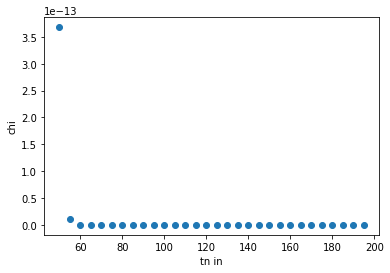

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.5 5. ]
Intensity:  [330.3 330.3 330.3]


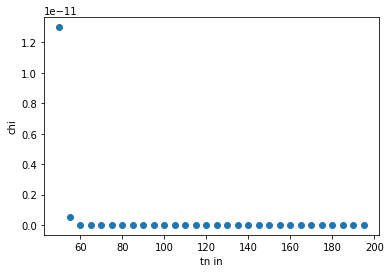

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.5 5.  5.5]
Intensity:  [330.3 330.3 330.3 330.3]


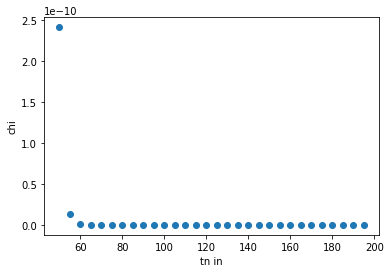

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  1
delta T:  [0.55127496]
curtemp:  6.0
Temperature:  [3.5 4.5 5.  5.5 6. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3]


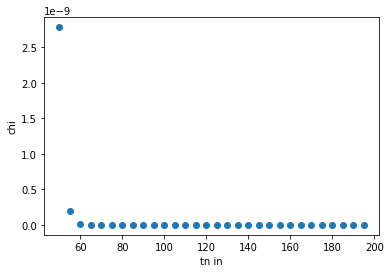

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  1
delta T:  [0.7646567]
curtemp:  7.0
Temperature:  [3.5 4.5 5.  5.5 6.  7. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3]


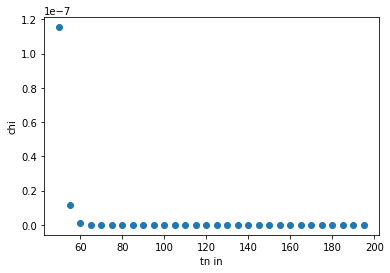

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  7.5
Temperature:  [3.5 4.5 5.  5.5 6.  7.  7.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3]


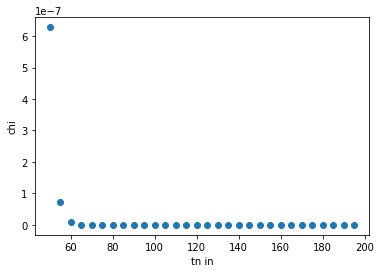

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  1
delta T:  [0.7198817]
curtemp:  8.0
Temperature:  [3.5 4.5 5.  5.5 6.  7.  7.5 8. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


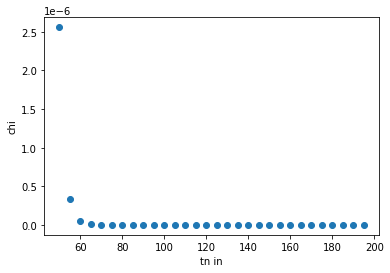

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  1
delta T:  [0.531343]
curtemp:  8.5
Temperature:  [3.5 4.5 5.  5.5 6.  7.  7.5 8.  8.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


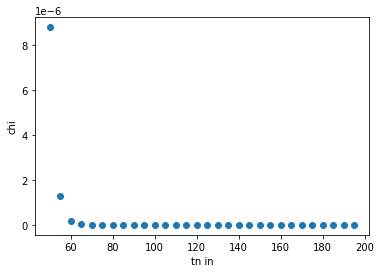

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.383
highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  9.0
Temperature:  [3.5 4.5 5.  5.5 6.  7.  7.5 8.  8.5 9. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


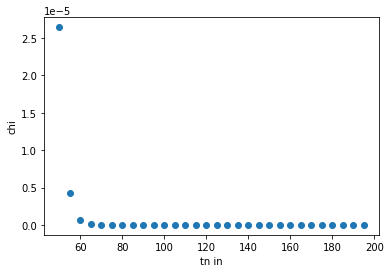

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.383
highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  9.5
Temperature:  [3.5 4.5 5.  5.5 6.  7.  7.5 8.  8.5 9.  9.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


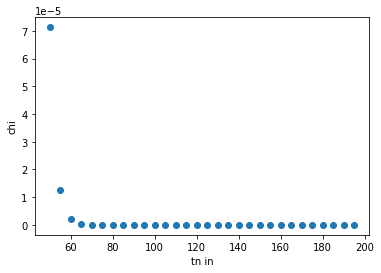

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.383
highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  1
delta T:  [0.52082735]
curtemp:  10.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


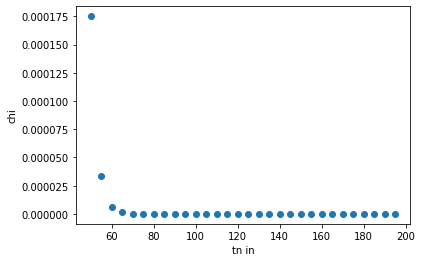

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4408529077107.285
highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3]


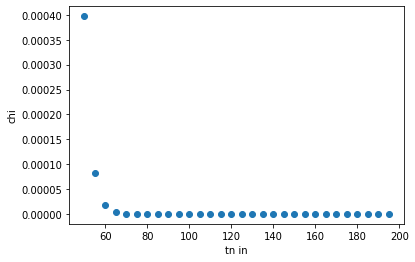

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1199849639459.359
highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  11.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3 330.3]


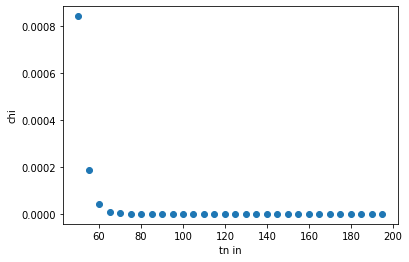

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 275802537375.93555
highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  1
delta T:  [0.503018]
curtemp:  11.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3 330.3 330.3]


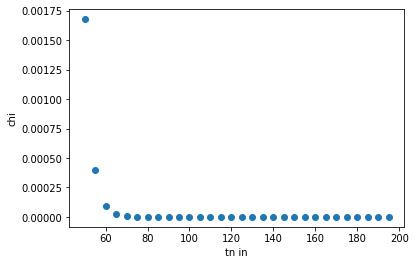

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 87003852500.9061
highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  1
delta T:  [1.0482198]
curtemp:  12.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999]


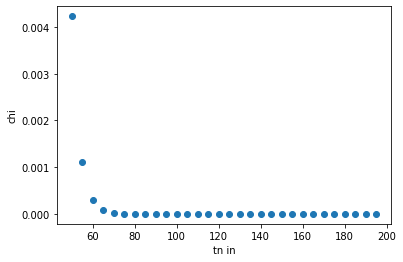

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 11550312732.152288
highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  13.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997]


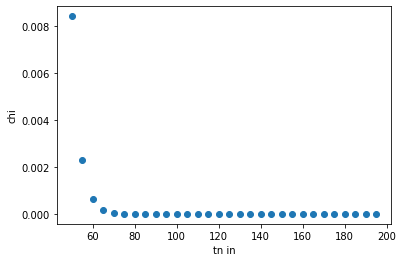

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4312934543.567621
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  13.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992]


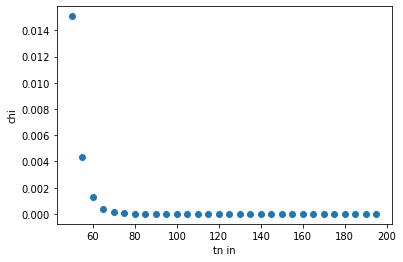

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1809773175.809823
highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  14.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982]


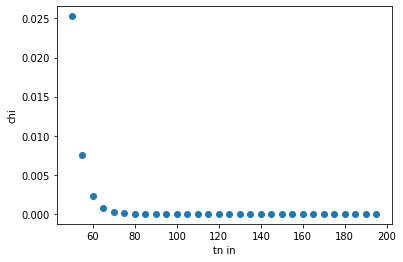

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 812838364.1774955
highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  1
delta T:  [0.7389562]
curtemp:  14.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962]


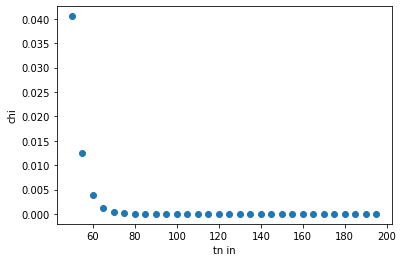

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 386029939.48585254
highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  1
delta T:  [1.1117462]
curtemp:  15.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985 ]


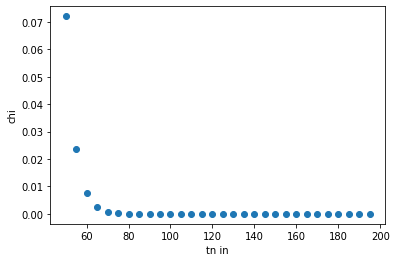

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 112723947.43912876
highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  16.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719]


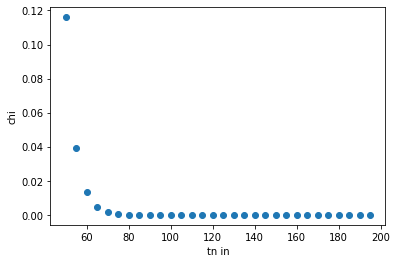

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 56356358.04888641
highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  16.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494]


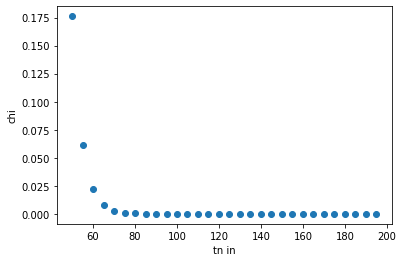

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 31093121.089849733
highHIIIIGHHHHHH:  323.5
rewaRD::  -100
stepping:  1
delta T:  [0.82479924]
curtemp:  17.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518]


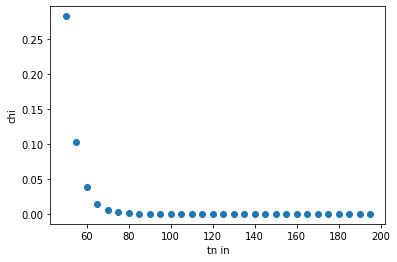

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 12380926.210982941
highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  1
delta T:  [0.5340965]
curtemp:  18.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575]


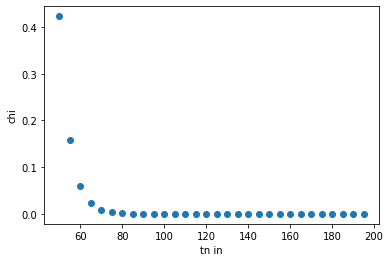

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6997704.739540679
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  1
delta T:  [0.58391786]
curtemp:  18.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135]


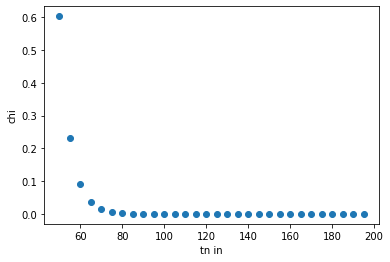

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4309912.174890616
highHIIIIGHHHHHH:  321.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  19.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399 ]


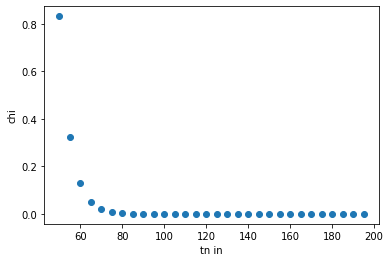

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2768889.572711104
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  19.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864]


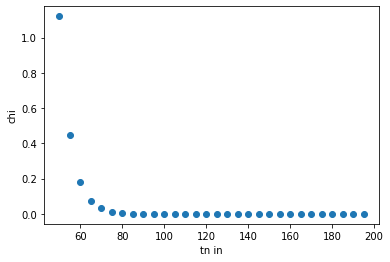

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1830349.4260679262
highHIIIIGHHHHHH:  320.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  20.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864  ]


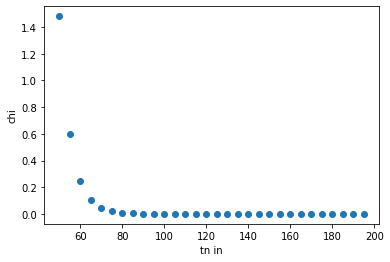

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1237917.6252268995
highHIIIIGHHHHHH:  320.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  20.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143]


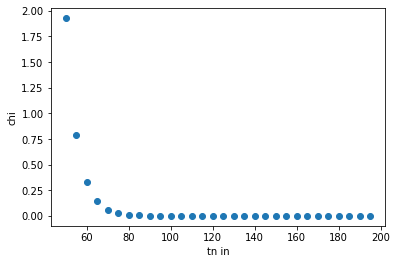

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 854050.3290593307
highHIIIIGHHHHHH:  319.5
rewaRD::  -100
stepping:  1
delta T:  [1.039253]
curtemp:  21.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847]


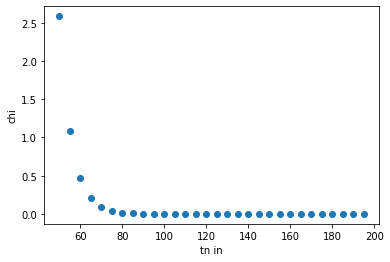

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 497404.3557138647
highHIIIIGHHHHHH:  318.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  22.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256]


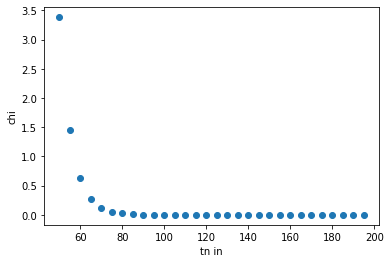

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 334107.7227039265
highHIIIIGHHHHHH:  318.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  22.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733]


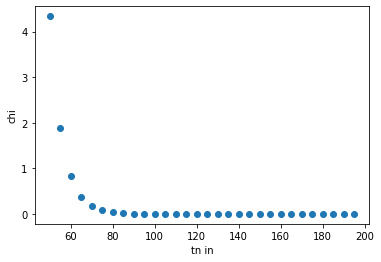

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 237306.5101110577
highHIIIIGHHHHHH:  317.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  23.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065]


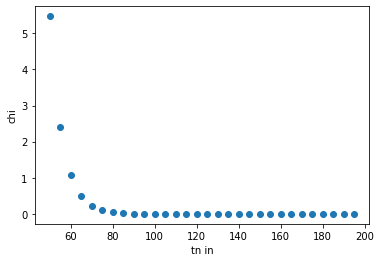

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 173821.9084879649
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  23.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833]


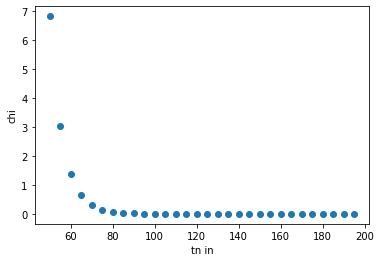

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 129979.52396782779
highHIIIIGHHHHHH:  316.5
rewaRD::  -100
stepping:  1
delta T:  [1.3369137]
curtemp:  25.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041]


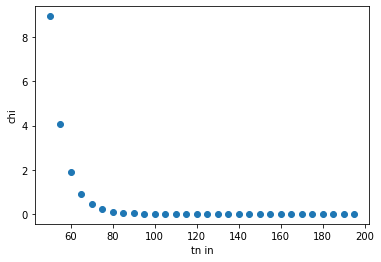

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 76320.3831910762
highHIIIIGHHHHHH:  315.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  25.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543]


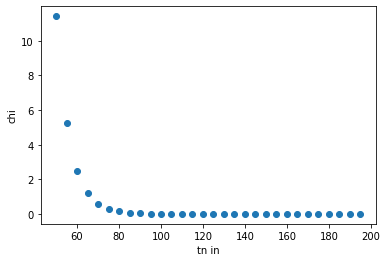

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 53634.80749492026
highHIIIIGHHHHHH:  314.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  26.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624]


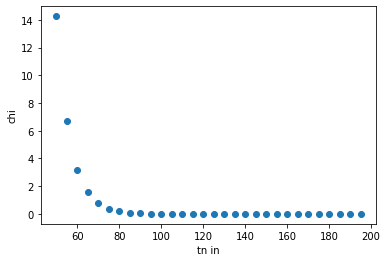

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 40228.71976929615
highHIIIIGHHHHHH:  314.0
rewaRD::  -100
stepping:  1
delta T:  [1.081669]
curtemp:  27.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077]


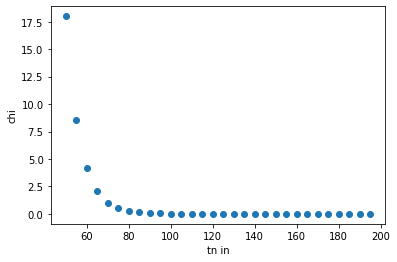

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 28573.19757947142
highHIIIIGHHHHHH:  313.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  27.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423]


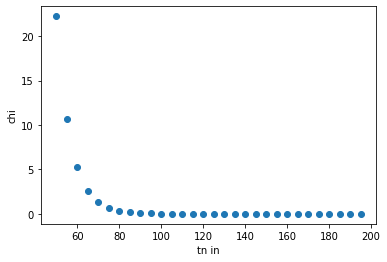

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 21751.40296560654
highHIIIIGHHHHHH:  312.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  28.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428 ]


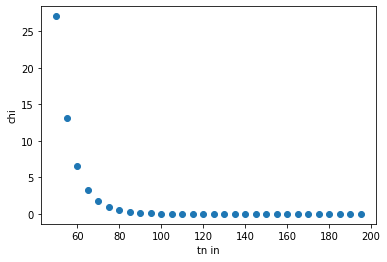

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 17158.2833516213
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  28.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304]


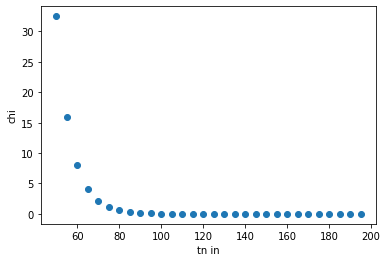

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 13835.475025061458
highHIIIIGHHHHHH:  311.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  29.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806]


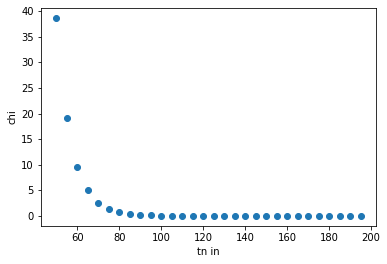

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 11327.207066153622
highHIIIIGHHHHHH:  311.0
rewaRD::  -100
stepping:  1
delta T:  [1.2936567]
curtemp:  30.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192]


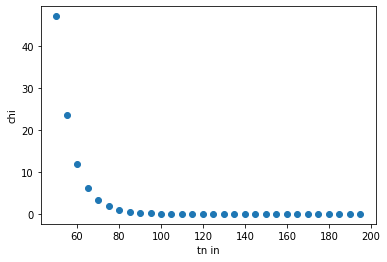

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 8317.407579988292
highHIIIIGHHHHHH:  309.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  31.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330.26649928]


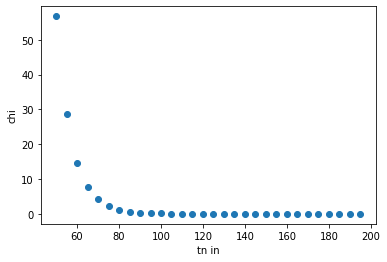

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6535.625802135038
highHIIIIGHHHHHH:  309.0
rewaRD::  -100
stepping:  1
delta T:  [2.8629167]
curtemp:  34.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330.26649928
 330.2189

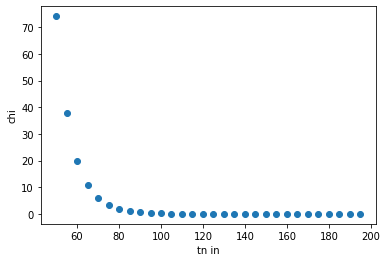

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3860.682871052771
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  34.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330.26649928
 330.21891

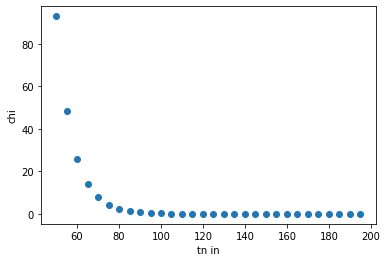

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2858.3279187697553
highHIIIIGHHHHHH:  305.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  35.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330.26649928
 330

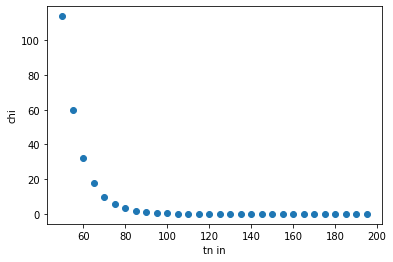

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2282.5950471085052
highHIIIIGHHHHHH:  305.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  35.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330.26649928

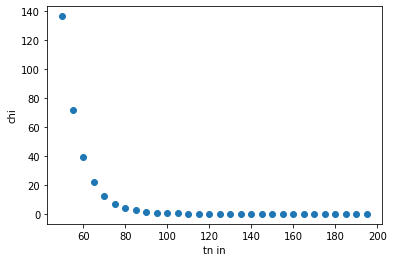

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1894.0400013195463
highHIIIIGHHHHHH:  304.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  36.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330.266

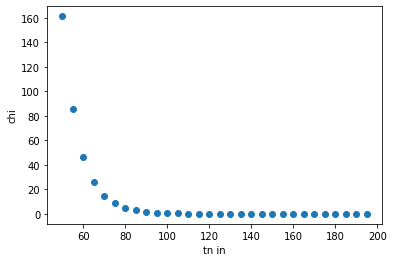

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1608.572078620919
highHIIIIGHHHHHH:  304.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  36.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.27157192 330

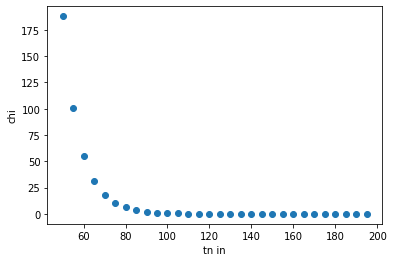

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1387.703458024426
highHIIIIGHHHHHH:  303.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  37.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 330.2715719

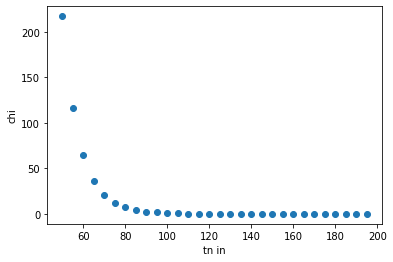

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1210.8368087559259
highHIIIIGHHHHHH:  303.0
rewaRD::  -100
stepping:  1
delta T:  [0.7222783]
curtemp:  37.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806

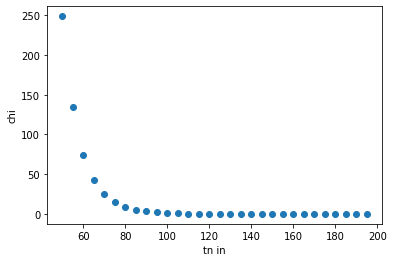

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1065.729057416127
highHIIIIGHHHHHH:  302.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  38.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320806 3

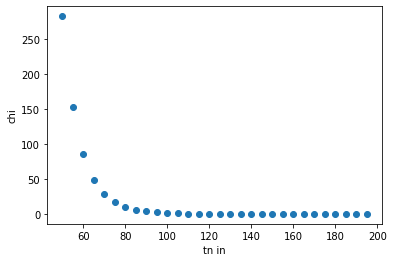

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 944.5293857604701
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  38.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.28320

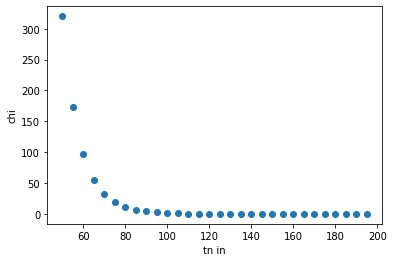

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 841.9059376656656
highHIIIIGHHHHHH:  301.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  39.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28608304 330.

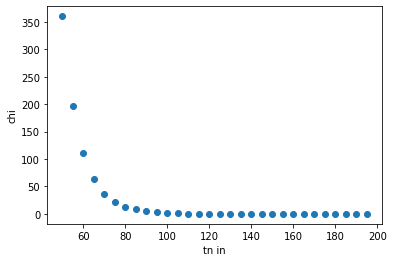

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 754.0716130303207
highHIIIIGHHHHHH:  301.0
rewaRD::  -100
stepping:  1
delta T:  [1.3399451]
curtemp:  40.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.28

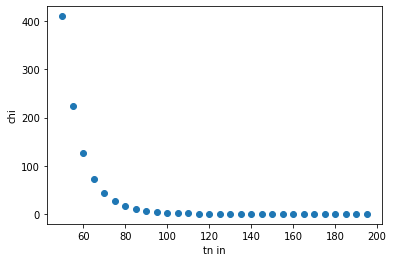

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 653.3798222688558
highHIIIIGHHHHHH:  299.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  41.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  330.286

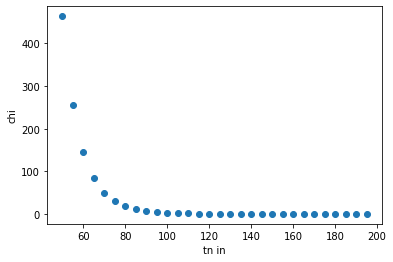

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 574.4678308653783
highHIIIIGHHHHHH:  299.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  41.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.2885428  33

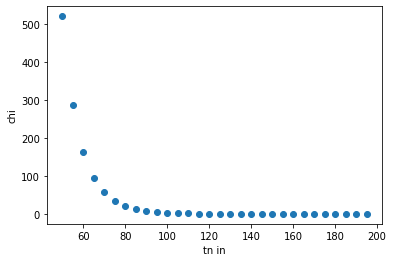

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 510.50835133308107
highHIIIIGHHHHHH:  298.5
rewaRD::  -100
stepping:  1
delta T:  [1.1404086]
curtemp:  42.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330

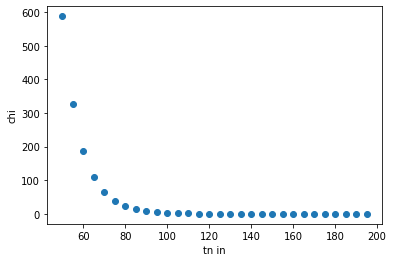

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 450.17021385747023
highHIIIIGHHHHHH:  297.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  43.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063423
 330.

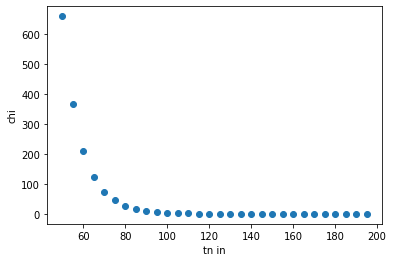

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 401.36882365343706
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  1
delta T:  [1.6173713]
curtemp:  44.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.290

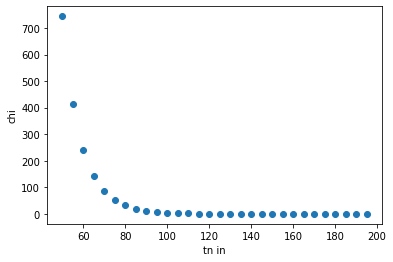

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 350.2301529502953
highHIIIIGHHHHHH:  295.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  45.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29240077 330.29063

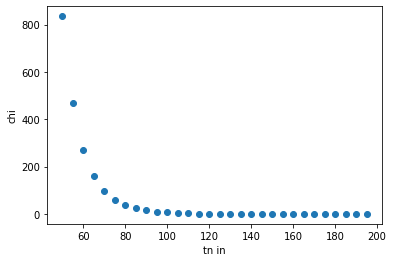

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 310.4093901154106
highHIIIIGHHHHHH:  295.0
rewaRD::  -100
stepping:  1
delta T:  [0.5959723]
curtemp:  45.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.2924007

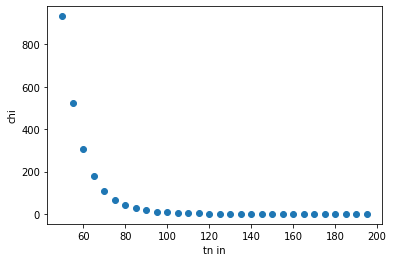

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 278.23163449671335
highHIIIIGHHHHHH:  294.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  46.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.2924007

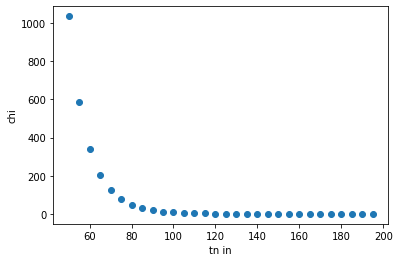

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 251.52782831209504
highHIIIIGHHHHHH:  294.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  46.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 330.29

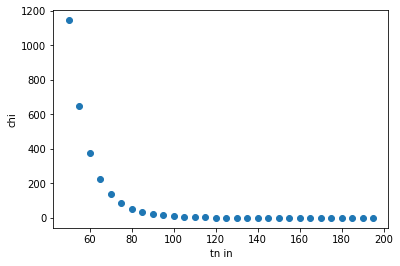

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 228.9197741759369
highHIIIIGHHHHHH:  293.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  47.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511624 33

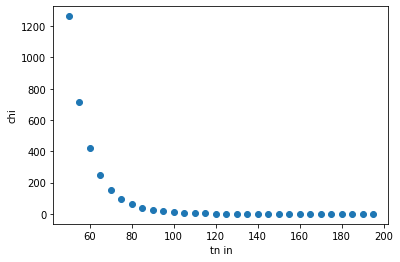

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 209.48125794178404
highHIIIIGHHHHHH:  293.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  47.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.29511

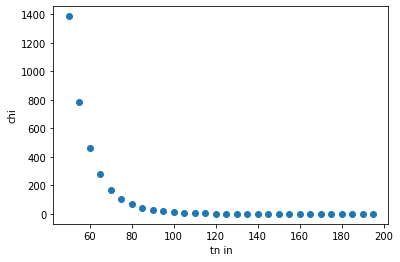

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 192.56177673086904
highHIIIIGHHHHHH:  292.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  48.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29613543 330.

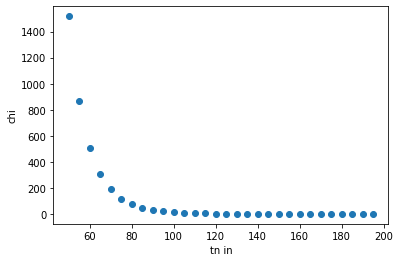

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 177.68788380671336
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
stepping:  1
delta T:  [1.1423643]
curtemp:  49.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.29

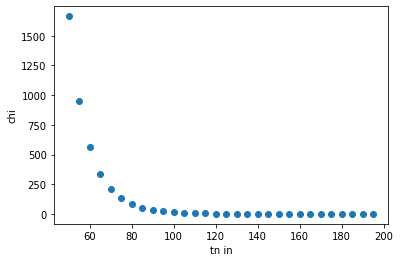

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 163.11544782274032
highHIIIIGHHHHHH:  291.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  49.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 330.296

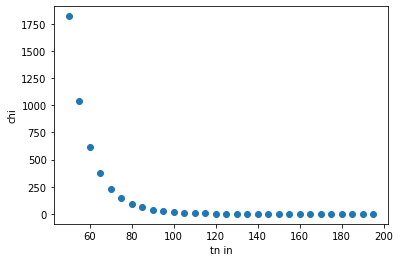

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 150.43299008771592
highHIIIIGHHHHHH:  290.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  50.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29697041 33

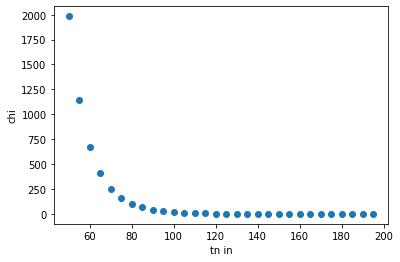

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 139.27860536028197
highHIIIIGHHHHHH:  290.0
rewaRD::  -100
stepping:  1
delta T:  [1.3707014]
curtemp:  51.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.

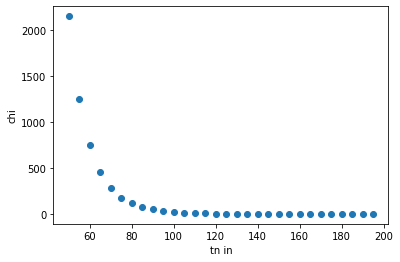

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 127.39680380731475
highHIIIIGHHHHHH:  288.5
rewaRD::  -100
stepping:  1
delta T:  [1.2923915]
curtemp:  53.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833


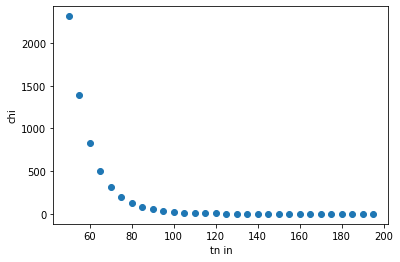

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 115.36912716490131
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  53.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 

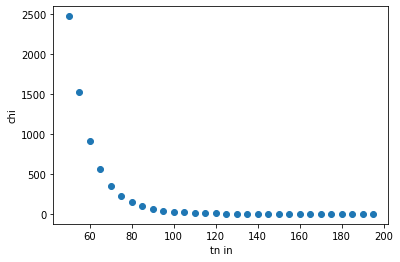

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 105.41521517817627
highHIIIIGHHHHHH:  286.5
rewaRD::  -100
stepping:  1
delta T:  [1.1768224]
curtemp:  54.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330

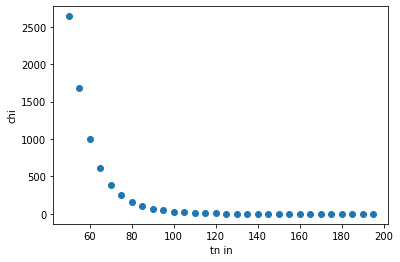

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 96.29104671156121
highHIIIIGHHHHHH:  285.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  55.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.2

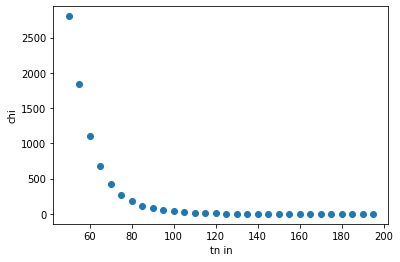

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 88.60043716959781
highHIIIIGHHHHHH:  285.0
rewaRD::  -100
stepping:  1
delta T:  [0.7828083]
curtemp:  56.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.298

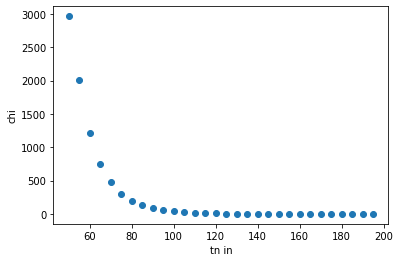

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 81.47429133999248
highHIIIIGHHHHHH:  284.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  56.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.2989

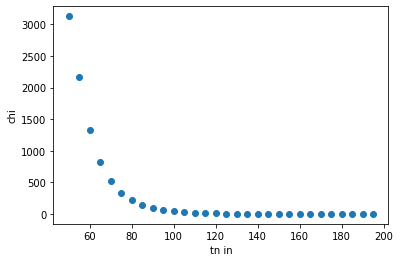

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 75.38495898948894
highHIIIIGHHHHHH:  283.5
rewaRD::  -100
stepping:  1
delta T:  [1.1972275]
curtemp:  57.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.299237

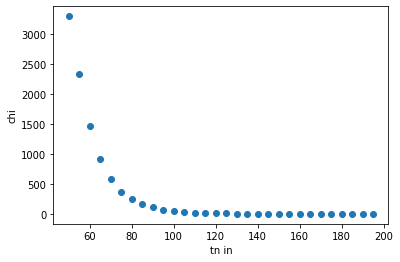

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 69.69939123198971
highHIIIIGHHHHHH:  282.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  58.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.2992373

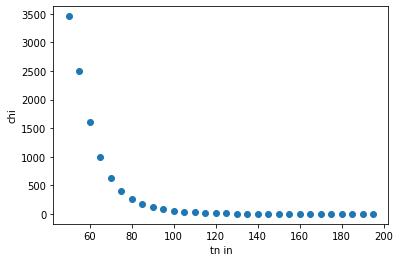

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 64.78826329813779
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  58.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29

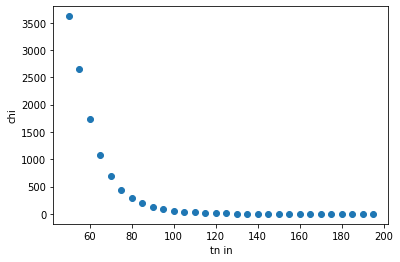

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 60.489365809892114
highHIIIIGHHHHHH:  281.5
rewaRD::  -100
stepping:  1
delta T:  [1.9771322]
curtemp:  60.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.299

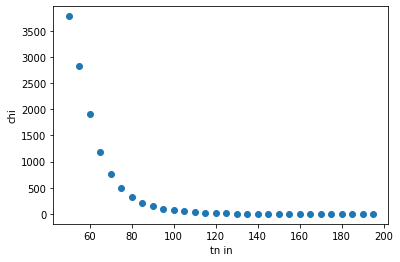

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 55.826296074889406
highHIIIIGHHHHHH:  279.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  61.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.2994

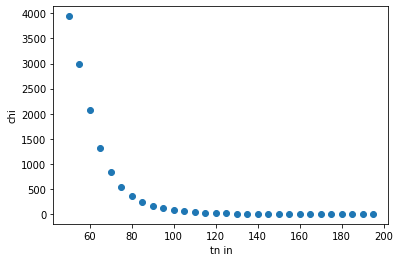

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 51.84461734896855
highHIIIIGHHHHHH:  279.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  61.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.

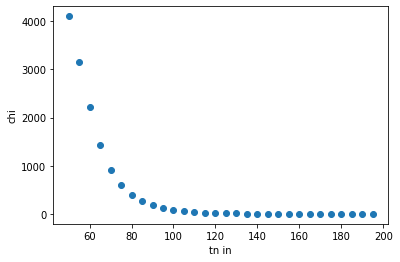

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 48.390742588872875
highHIIIIGHHHHHH:  278.5
rewaRD::  -100
stepping:  1
delta T:  [0.958022]
curtemp:  62.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29

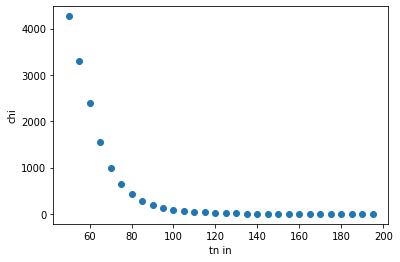

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 45.15801867021755
highHIIIIGHHHHHH:  277.5
rewaRD::  -100
stepping:  1
delta T:  [2.4302123]
curtemp:  65.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 3

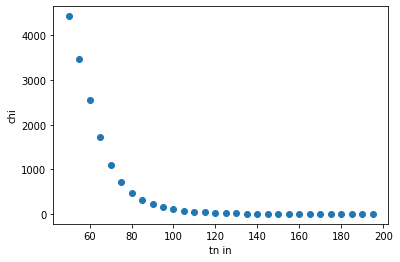

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 41.56282750357937
highHIIIIGHHHHHH:  275.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  65.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 33

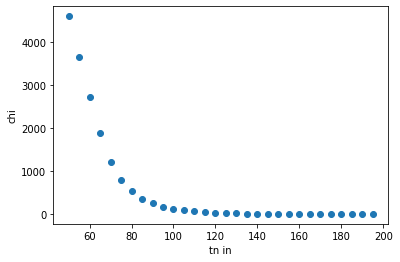

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 38.54011998030214
highHIIIIGHHHHHH:  274.5
rewaRD::  -100
stepping:  1
delta T:  [0.6004619]
curtemp:  66.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.2

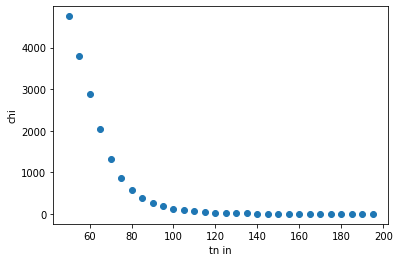

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 35.949615347310946
highHIIIIGHHHHHH:  274.0
rewaRD::  -100
stepping:  1
delta T:  [0.7183618]
curtemp:  66.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864  

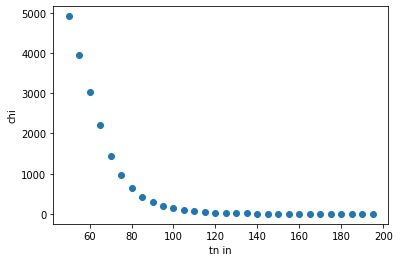

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 33.695432035935454
highHIIIIGHHHHHH:  273.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  67.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   

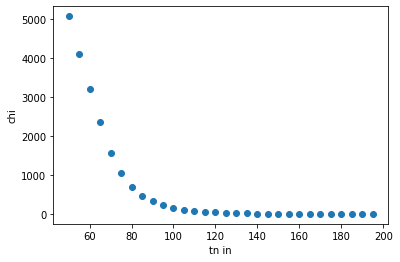

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 31.70945005957379
highHIIIIGHHHHHH:  273.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  67.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330.29986

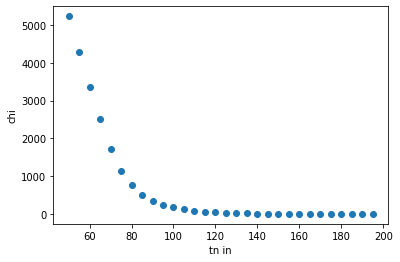

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 29.941719154734855
highHIIIIGHHHHHH:  272.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  68.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29990864 330

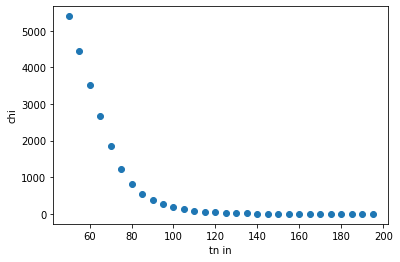

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 28.354635602137982
highHIIIIGHHHHHH:  272.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  68.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.2999086

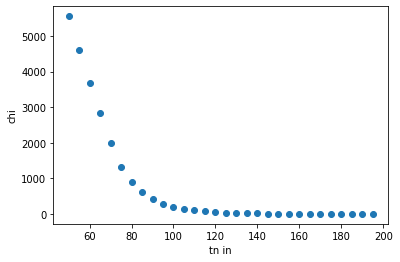

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 26.919252868496724
highHIIIIGHHHHHH:  271.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  69.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  330.29

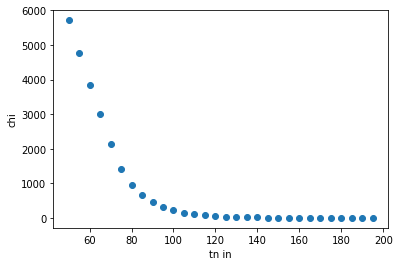

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 25.612858797857246
highHIIIIGHHHHHH:  271.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  69.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2999399  3

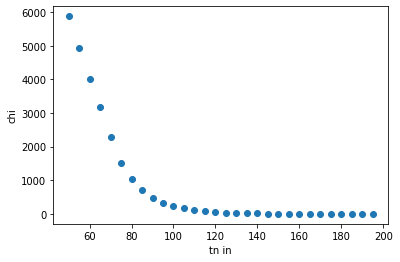

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 24.41733521675006
highHIIIIGHHHHHH:  270.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  70.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.299939

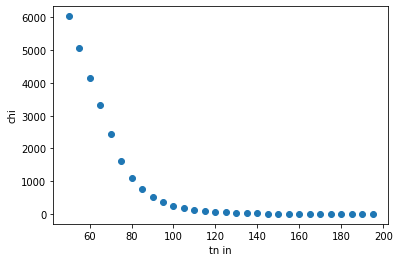

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 23.31801713103464
highHIIIIGHHHHHH:  270.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  70.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29996135 330.2

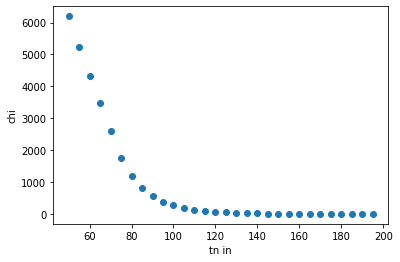

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 22.302881648414388
highHIIIIGHHHHHH:  269.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  71.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5
 71. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.2999613

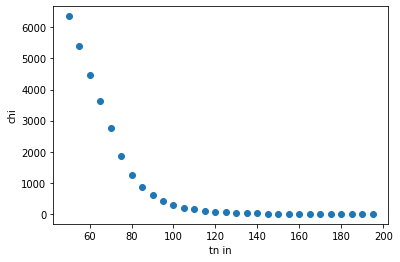

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 21.361958785479562
highHIIIIGHHHHHH:  269.0
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  71.5
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5
 71.  71.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 330.29

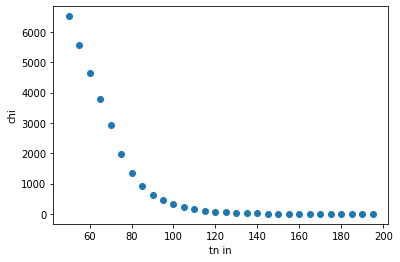

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 20.48689601611682
highHIIIIGHHHHHH:  268.5
rewaRD::  -100
stepping:  1
delta T:  [0.5]
curtemp:  72.0
Temperature:  [ 3.5  4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.5 13.  13.5 14.  14.5 15.5 16.  16.5 17.5 18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 25.  25.5 26.  27.  27.5 28.  28.5
 29.  30.5 31.  34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.
 40.5 41.  41.5 42.5 43.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  49.
 49.5 50.  51.5 53.  53.5 54.5 55.  56.  56.5 57.5 58.  58.5 60.5 61.
 61.5 62.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5
 71.  71.5 72. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.29999999 330.29999997 330.29999992 330.29999982 330.29999962
 330.2999985  330.29999719 330.29999494 330.29998518 330.29997575
 33

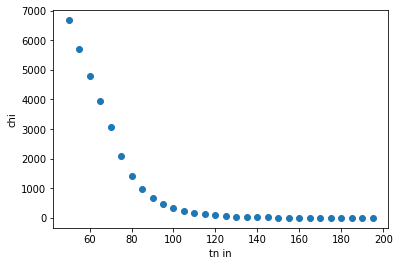

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 19.670631162183366
highHIIIIGHHHHHH:  268.0
rewaRD::  -100
terminated: too long
reset
stepping:  2
delta T:  [0.6859871]
curtemp:  3.5
Temperature:  [3.5]
highHIIIIGHHHHHH:  336.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  4.0
Temperature:  [3.5 4. ]
Intensity:  [330.3 330.3]


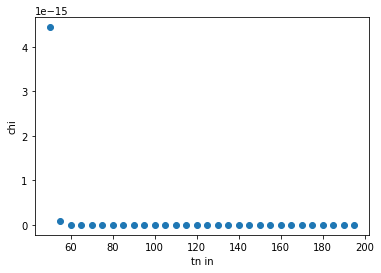

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
stepping:  2
delta T:  [0.54282784]
curtemp:  4.5
Temperature:  [3.5 4.  4.5]
Intensity:  [330.3 330.3 330.3]


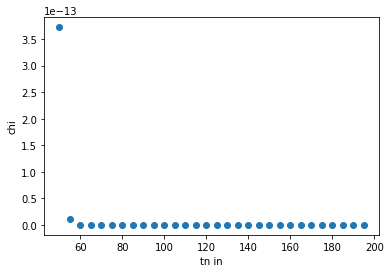

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  5.0
Temperature:  [3.5 4.  4.5 5. ]
Intensity:  [330.3 330.3 330.3 330.3]


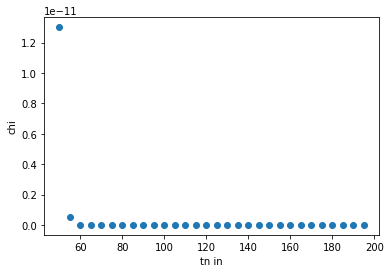

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  5.5
Temperature:  [3.5 4.  4.5 5.  5.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3]


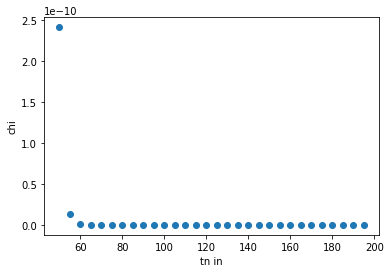

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  6.0
Temperature:  [3.5 4.  4.5 5.  5.5 6. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3]


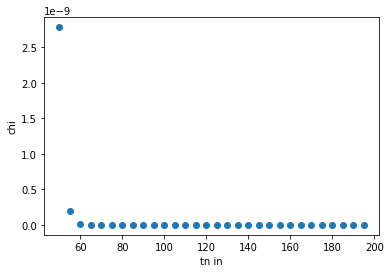

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.0
rewaRD::  -100
stepping:  2
delta T:  [0.7978102]
curtemp:  7.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3]


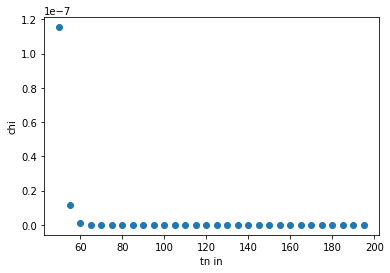

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  7.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.  7.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


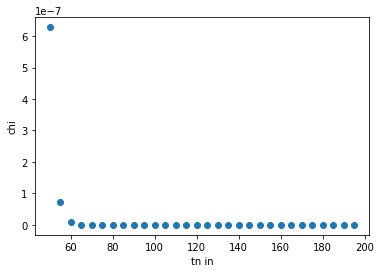

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  332.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  8.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.  7.5 8. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


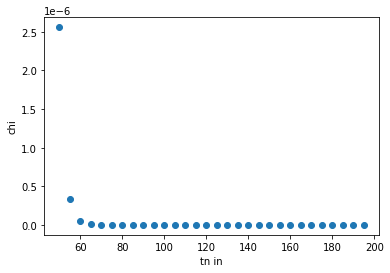

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  8.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.  7.5 8.  8.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


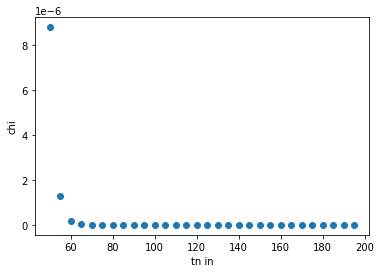

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.383
highHIIIIGHHHHHH:  331.5
rewaRD::  -100
stepping:  2
delta T:  [0.6513152]
curtemp:  9.0
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.  7.5 8.  8.5 9. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


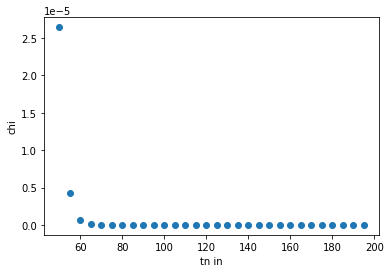

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.383
highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  9.5
Temperature:  [3.5 4.  4.5 5.  5.5 6.  7.  7.5 8.  8.5 9.  9.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


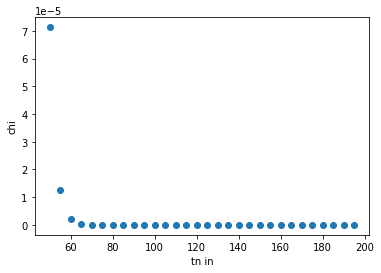

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.383
highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  10.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3]


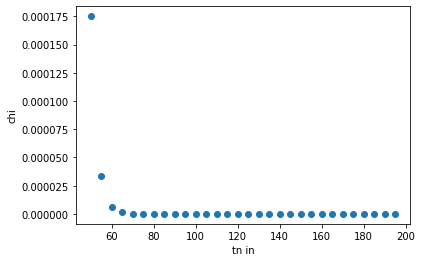

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4408529077107.285
highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  10.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3 330.3]


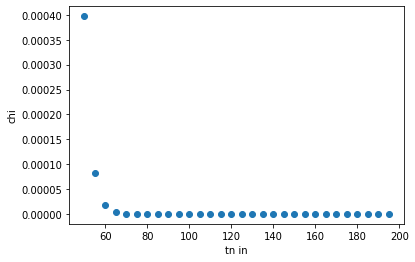

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1199849639459.359
highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  11.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3 330.3 330.3]


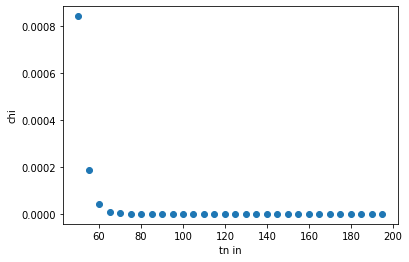

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 275802537375.93555
highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  11.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3 330.3 330.3 330.3]


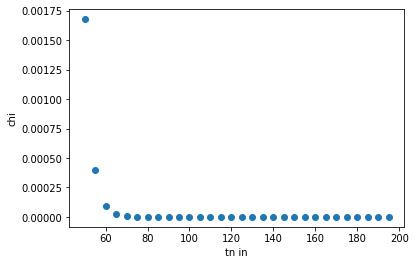

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 87003852500.9061
highHIIIIGHHHHHH:  328.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  12.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3
 330.3 330.3 330.3 330.3 330.3]


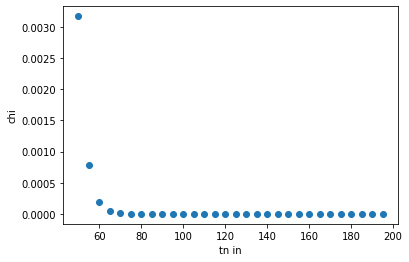

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 29346207501.006187
highHIIIIGHHHHHH:  328.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  12.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999]


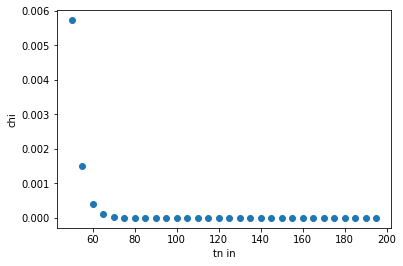

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 10830753373.26842
highHIIIIGHHHHHH:  327.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  13.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997]


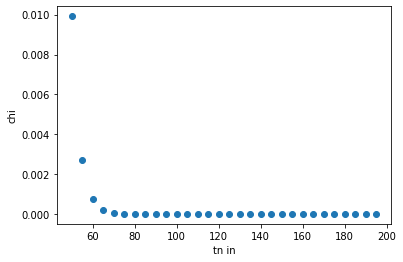

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4272238680.4708014
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  13.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992]


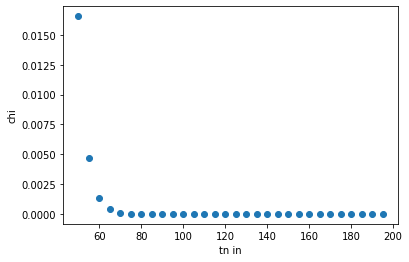

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1806730967.9758987
highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  14.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982]


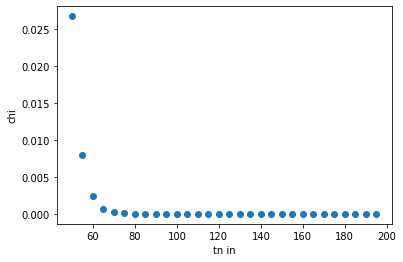

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 812562176.8366336
highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  14.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962]


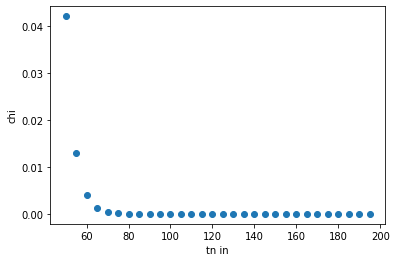

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 386000343.99133
highHIIIIGHHHHHH:  325.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  15.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923]


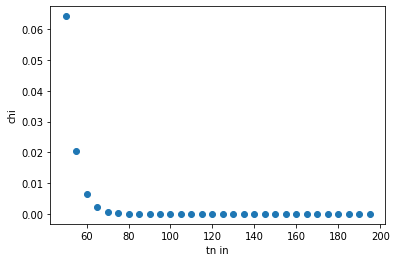

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 192652702.1659991
highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  2
delta T:  [1.7869368]
curtemp:  17.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912 ]


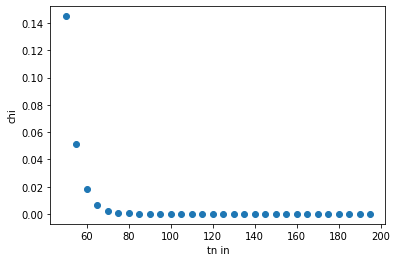

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 21945617.714111604
highHIIIIGHHHHHH:  323.0
rewaRD::  -100
stepping:  2
delta T:  [1.101624]
curtemp:  18.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575]


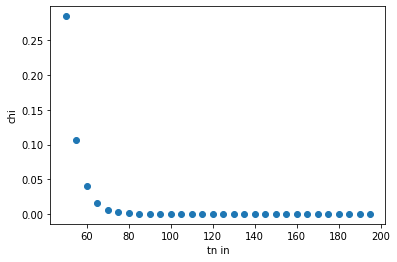

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 7912069.561685964
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  18.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135]


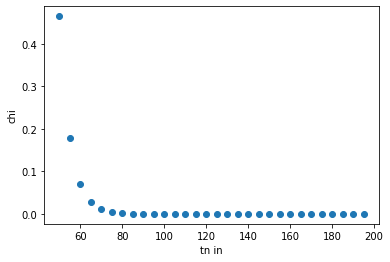

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4499783.009255551
highHIIIIGHHHHHH:  321.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  19.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399 ]


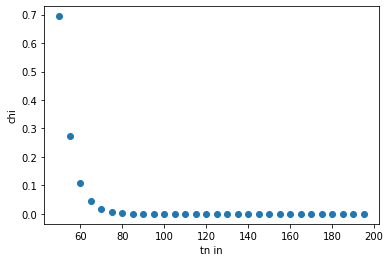

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2817336.858073152
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  19.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864]


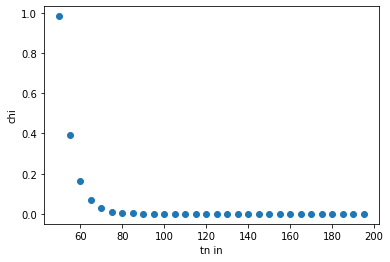

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1844139.2166020297
highHIIIIGHHHHHH:  320.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  20.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864  ]


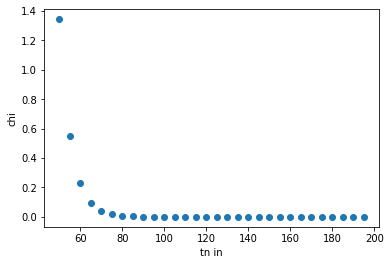

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1242157.6777691026
highHIIIIGHHHHHH:  320.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  20.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143]


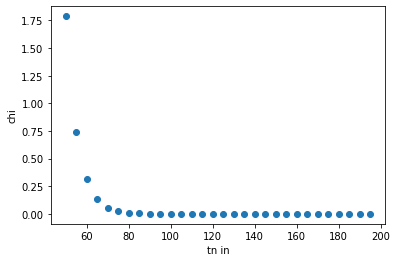

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 855438.930882636
highHIIIIGHHHHHH:  319.5
rewaRD::  -100
stepping:  2
delta T:  [0.75788754]
curtemp:  21.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847]


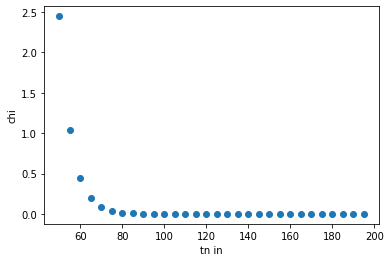

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 497678.2332996309
highHIIIIGHHHHHH:  318.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  22.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256]


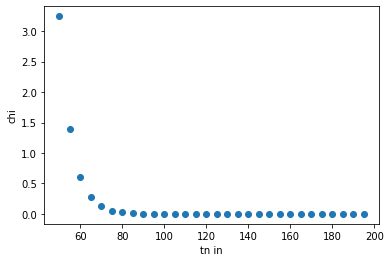

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 334190.6868492777
highHIIIIGHHHHHH:  318.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  22.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733]


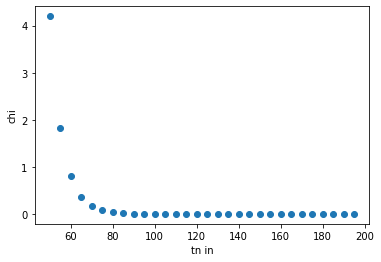

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 237336.23222567554
highHIIIIGHHHHHH:  317.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  23.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065]


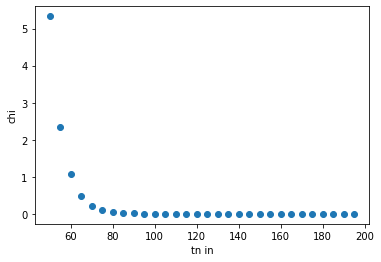

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 173833.5880477397
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  23.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833]


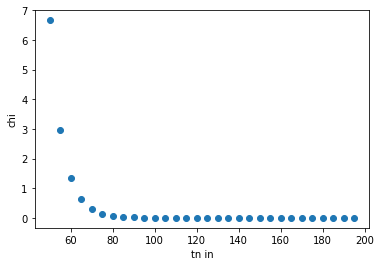

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 129984.40732468333
highHIIIIGHHHHHH:  316.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  24.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391]


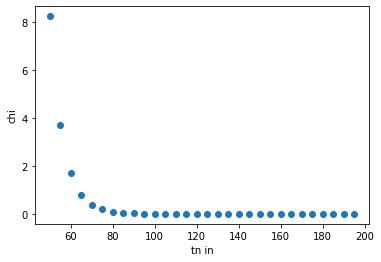

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 98743.7533580264
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  24.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845]


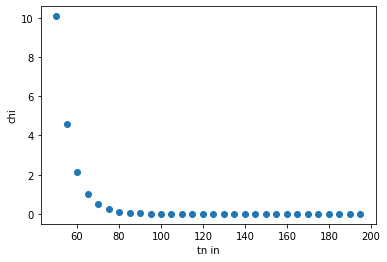

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 76001.45100766396
highHIIIIGHHHHHH:  315.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  25.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041]


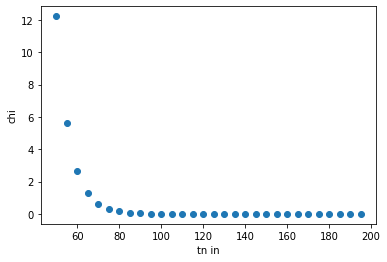

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 59171.2838392914
highHIIIIGHHHHHH:  315.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  25.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543]


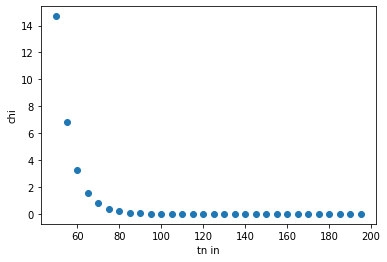

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 46546.64416208497
highHIIIIGHHHHHH:  314.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  26.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624]


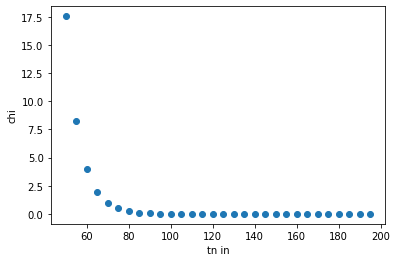

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 36964.93475881369
highHIIIIGHHHHHH:  314.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  26.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253]


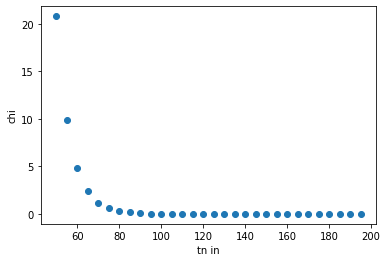

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 29615.866583215473
highHIIIIGHHHHHH:  313.5
rewaRD::  -100
stepping:  2
delta T:  [1.0731753]
curtemp:  27.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423]


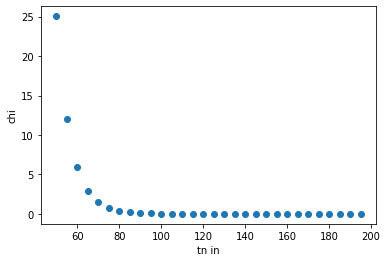

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 22200.930419813736
highHIIIIGHHHHHH:  312.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  28.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428 ]


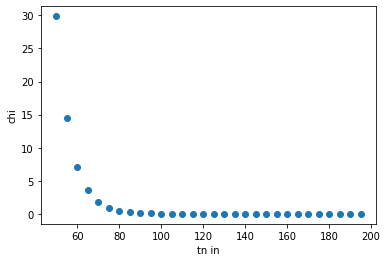

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 17376.37146375333
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  28.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304]


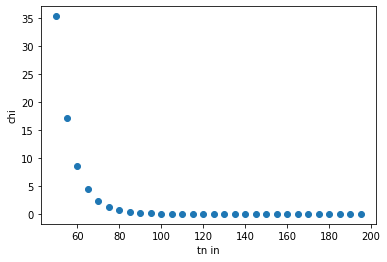

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 13949.053452886348
highHIIIIGHHHHHH:  311.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  29.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 330.28320806]


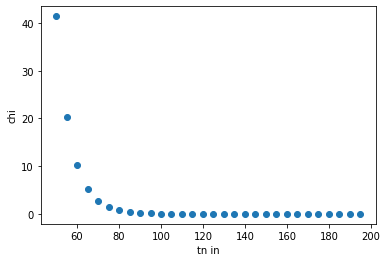

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 11389.282310362463
highHIIIIGHHHHHH:  311.0
rewaRD::  -100
stepping:  2
delta T:  [1.2839674]
curtemp:  30.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 330.28320806
 330.27

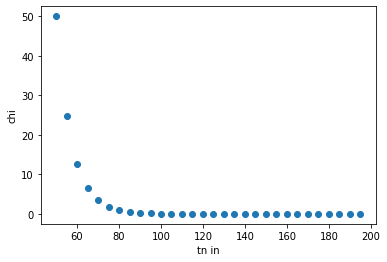

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 8341.890855699801
highHIIIIGHHHHHH:  309.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  31.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 330.28320806
 330.2715

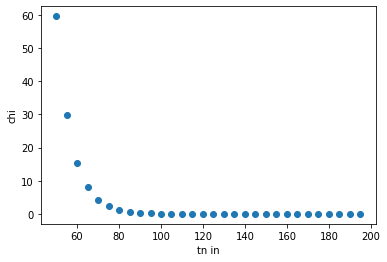

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6547.484405960441
highHIIIIGHHHHHH:  309.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  31.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 330.28320806
 330

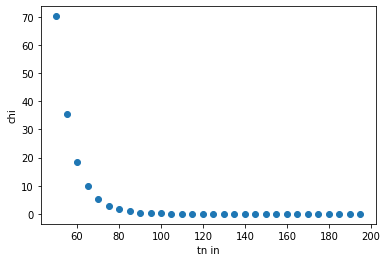

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 5326.249343227515
highHIIIIGHHHHHH:  308.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  32.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 330.28320806

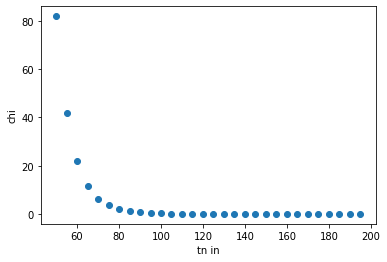

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4429.166336200683
highHIIIIGHHHHHH:  308.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  32.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 330.283

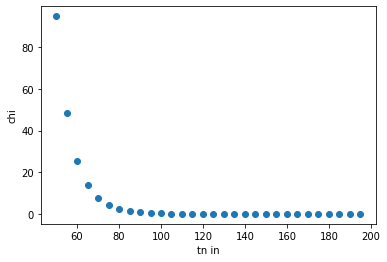

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3739.0250852072813
highHIIIIGHHHHHH:  307.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  33.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608304 3

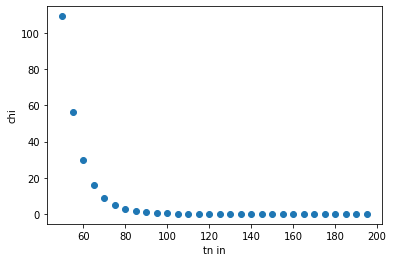

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3191.6518130900395
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  33.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.28608

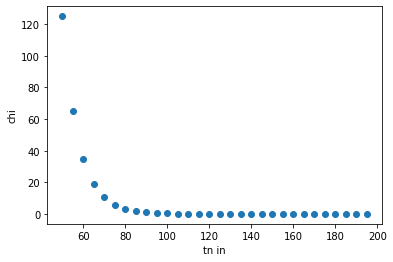

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2748.124044659303
highHIIIIGHHHHHH:  306.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  34.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885428  330.2

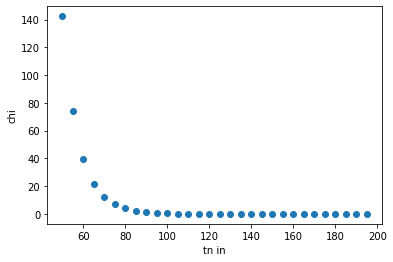

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2383.0279901998
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
stepping:  2
delta T:  [1.1938888]
curtemp:  35.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.28854

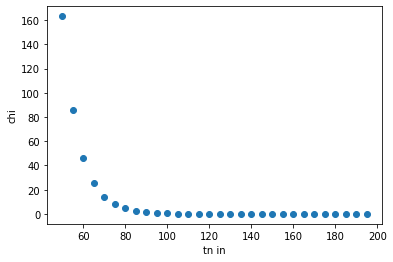

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2017.736642317415
highHIIIIGHHHHHH:  305.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  35.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.29063423 330.2885

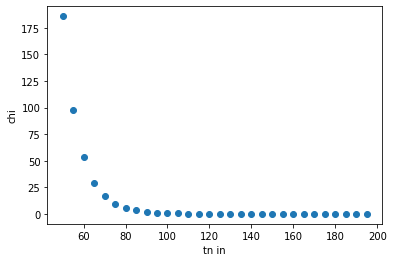

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1734.353512799323
highHIIIIGHHHHHH:  304.5
rewaRD::  -100
stepping:  2
delta T:  [1.1815405]
curtemp:  36.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330.290634

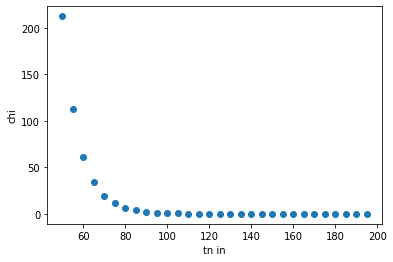

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1466.0581474791356
highHIIIIGHHHHHH:  303.5
rewaRD::  -100
stepping:  2
delta T:  [0.5604813]
curtemp:  37.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29388253 330

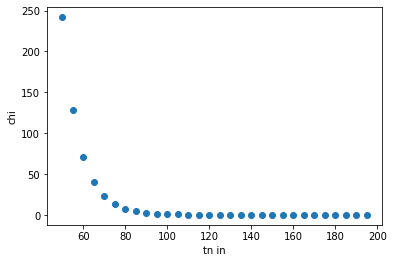

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1261.8402568923461
highHIIIIGHHHHHH:  303.0
rewaRD::  -100
stepping:  2
delta T:  [1.4137354]
curtemp:  38.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.2938825

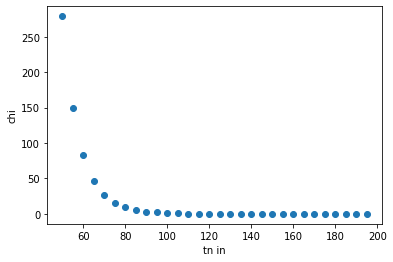

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1043.7275530538784
highHIIIIGHHHHHH:  301.5
rewaRD::  -100
stepping:  2
delta T:  [0.8571649]
curtemp:  39.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.29

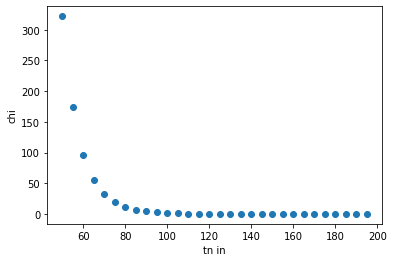

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 866.0657279727502
highHIIIIGHHHHHH:  300.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  40.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330.2938

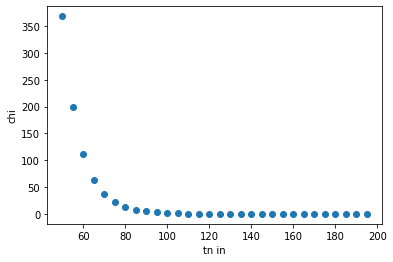

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 739.8940668495222
highHIIIIGHHHHHH:  300.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  40.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624
 330

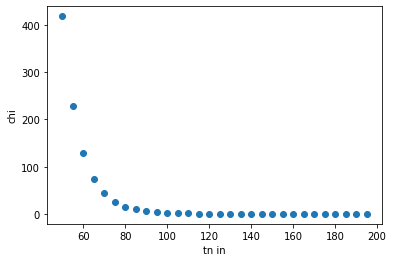

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 644.0921500110104
highHIIIIGHHHHHH:  299.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  41.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.29511624

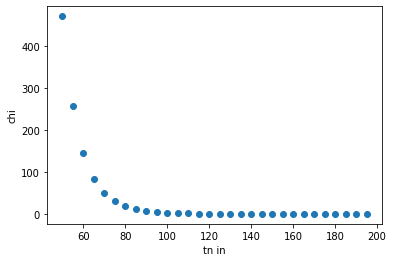

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 568.1246836827602
highHIIIIGHHHHHH:  299.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  41.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613543 330.295

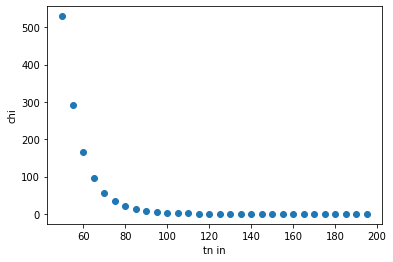

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 506.0412441047044
highHIIIIGHHHHHH:  298.5
rewaRD::  -100
stepping:  2
delta T:  [1.2990643]
curtemp:  43.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613

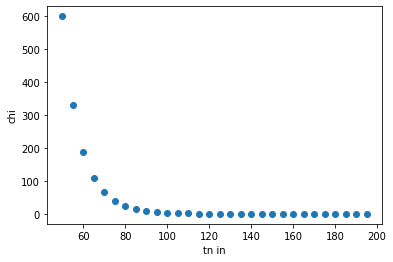

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 439.46093346472793
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  43.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.29613

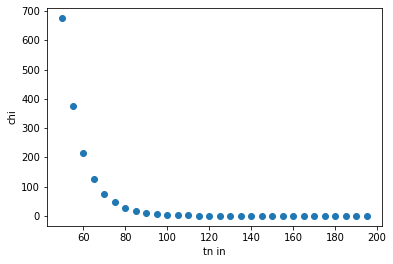

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 387.81046705816163
highHIIIIGHHHHHH:  296.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  44.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 330.

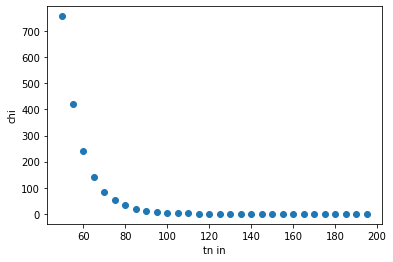

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 346.2004046254085
highHIIIIGHHHHHH:  296.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  44.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.29697041 

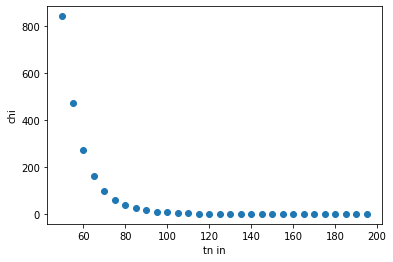

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 311.7620900780889
highHIIIIGHHHHHH:  295.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  45.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 330.2969

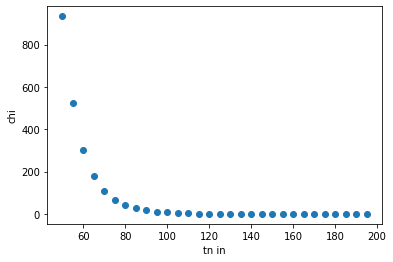

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 282.68005915171017
highHIIIIGHHHHHH:  295.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  45.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845 33

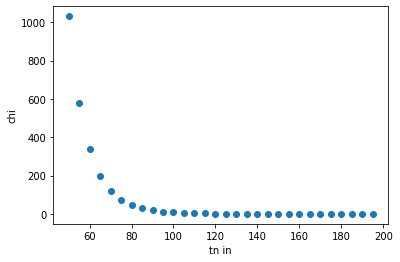

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 257.737566663331
highHIIIIGHHHHHH:  294.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  46.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.29764845

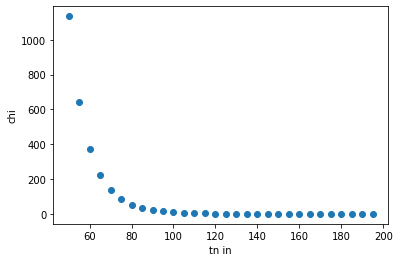

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 236.08155602286055
highHIIIIGHHHHHH:  294.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  46.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 330.2

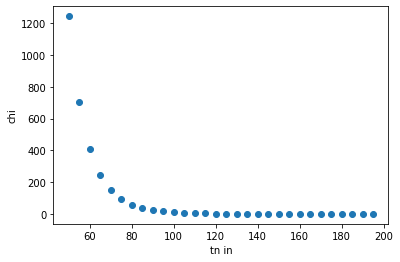

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 217.09188802023033
highHIIIIGHHHHHH:  293.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  47.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330.29819391 

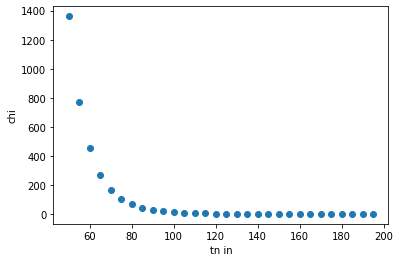

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 200.30400270672828
highHIIIIGHHHHHH:  293.0
rewaRD::  -100
stepping:  2
delta T:  [0.9992541]
curtemp:  48.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 33

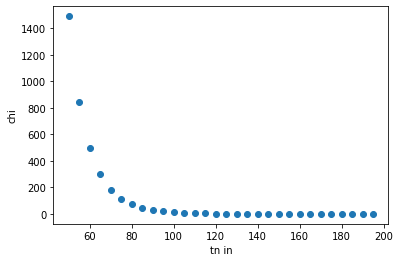

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 183.71637628573234
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  48.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833
 330

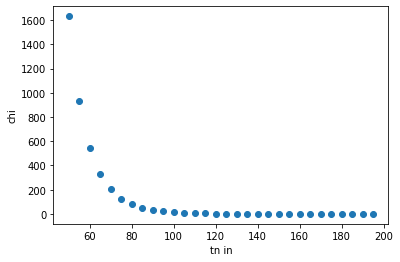

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 169.2535850792395
highHIIIIGHHHHHH:  291.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  49.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 330.29862833


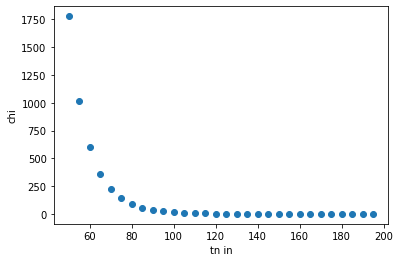

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 156.5179373028614
highHIIIIGHHHHHH:  291.0
rewaRD::  -100
stepping:  2
delta T:  [1.1613083]
curtemp:  50.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 33

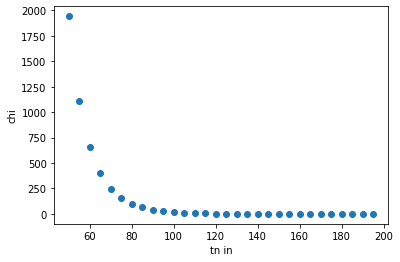

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 144.06587236393523
highHIIIIGHHHHHH:  290.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  50.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.29897065 33

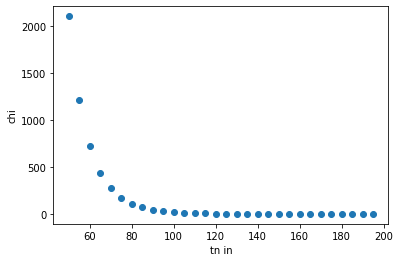

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 133.19319214698274
highHIIIIGHHHHHH:  289.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  51.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 330.298970

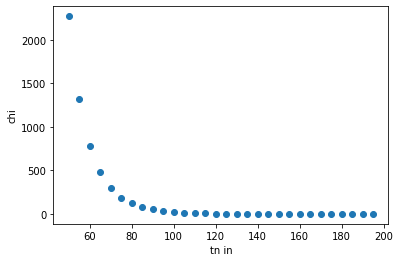

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 123.6028638577566
highHIIIIGHHHHHH:  289.0
rewaRD::  -100
stepping:  2
delta T:  [1.2663525]
curtemp:  52.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 

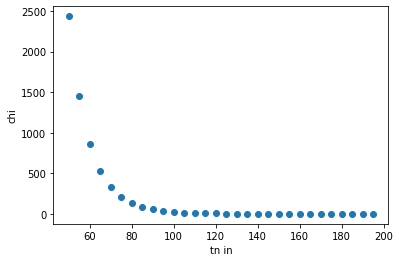

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 113.42483559188415
highHIIIIGHHHHHH:  287.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  53.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330.29923733 

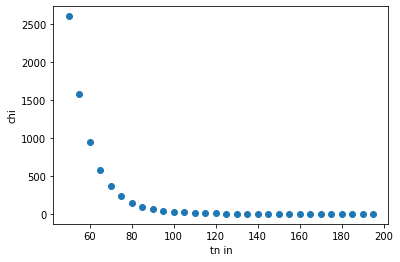

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 104.68714411044239
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
stepping:  2
delta T:  [1.996659]
curtemp:  55.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256 330

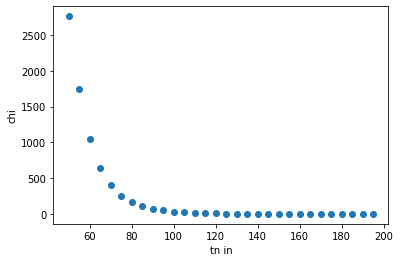

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 95.0092206636013
highHIIIIGHHHHHH:  285.0
rewaRD::  -100
stepping:  2
delta T:  [1.4134394]
curtemp:  56.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256

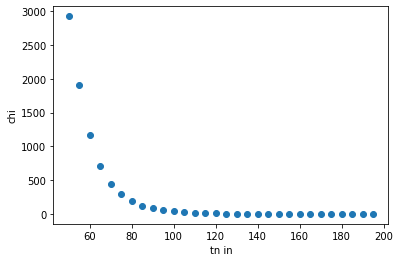

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 85.71711052758192
highHIIIIGHHHHHH:  283.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  57.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.29944256

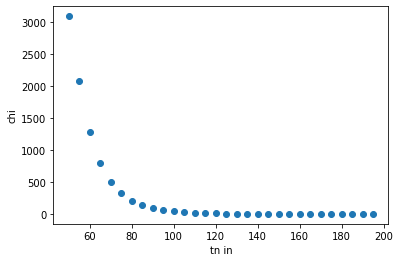

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 78.17583506722484
highHIIIIGHHHHHH:  283.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  57.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.29959847 330.299

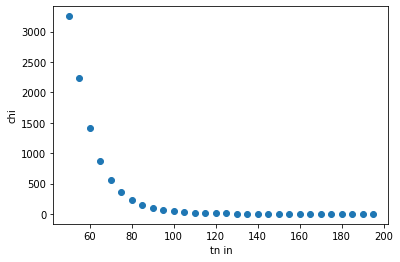

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 71.88739030805749
highHIIIIGHHHHHH:  282.5
rewaRD::  -100
stepping:  2
delta T:  [0.78184223]
curtemp:  58.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.299

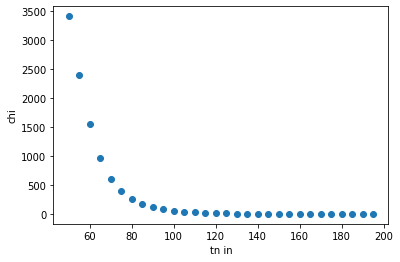

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 66.14376603291639
highHIIIIGHHHHHH:  281.5
rewaRD::  -100
stepping:  2
delta T:  [1.6614844]
curtemp:  60.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330

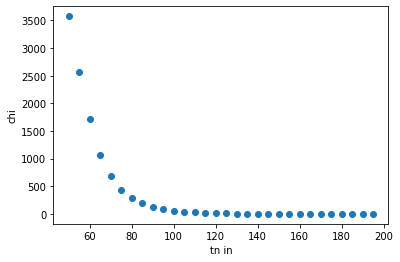

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 60.55324173631178
highHIIIIGHHHHHH:  280.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  60.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143
 330.

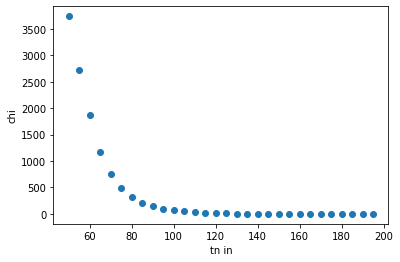

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 55.87649732908422
highHIIIIGHHHHHH:  279.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  61.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980143


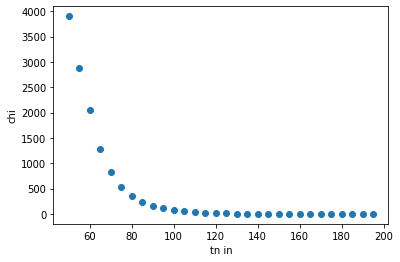

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 51.8848175798156
highHIIIIGHHHHHH:  279.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  61.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   330.29980

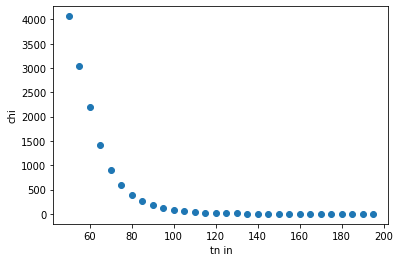

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 48.423426898423806
highHIIIIGHHHHHH:  278.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  62.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.299864   33

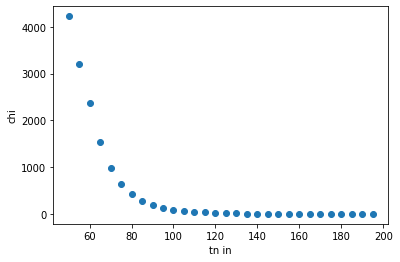

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 45.383216868322165
highHIIIIGHHHHHH:  278.0
rewaRD::  -100
stepping:  2
delta T:  [0.8010803]
curtemp:  63.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.

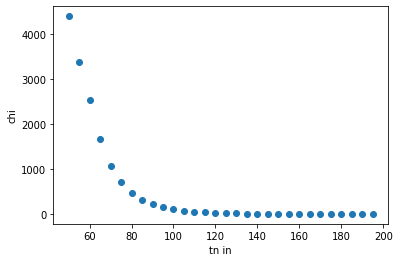

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 42.510076982653956
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  63.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 330.2

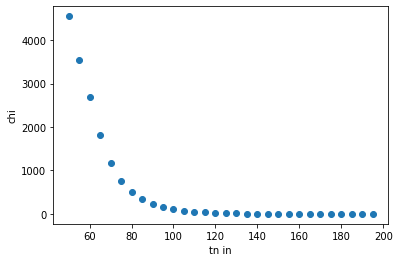

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 39.96849932114703
highHIIIIGHHHHHH:  276.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  64.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990864 3

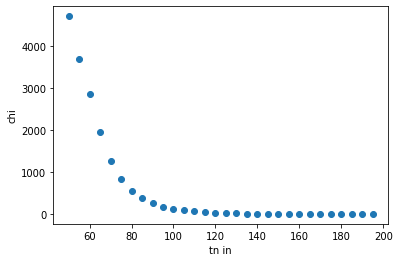

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 37.69894959750717
highHIIIIGHHHHHH:  276.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  64.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330.29990

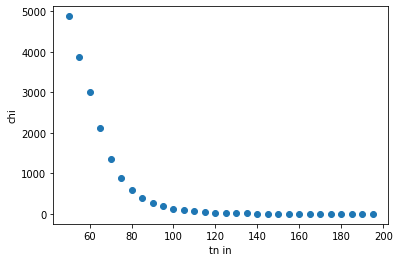

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 35.656153839879224
highHIIIIGHHHHHH:  275.5
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  65.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  330

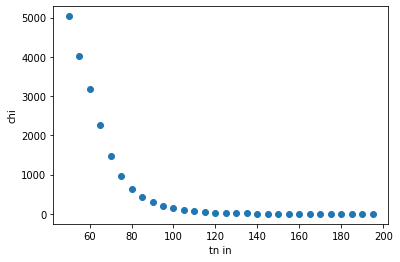

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 33.8049530302174
highHIIIIGHHHHHH:  275.0
rewaRD::  -100
stepping:  2
delta T:  [0.5]
curtemp:  65.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65.  65.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 330.2999399  

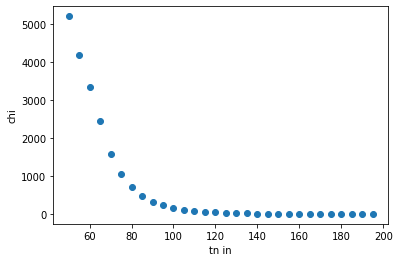

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 32.11754529411381
highHIIIIGHHHHHH:  274.5
rewaRD::  -100
stepping:  2
delta T:  [1.5649207]
curtemp:  67.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65.  65.5 67. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.29996135 3

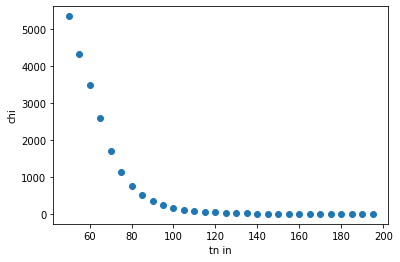

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 30.383946250957134
highHIIIIGHHHHHH:  273.0
rewaRD::  -100
stepping:  2
delta T:  [1.6570383]
curtemp:  68.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65.  65.5 67.  68.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 330.2999

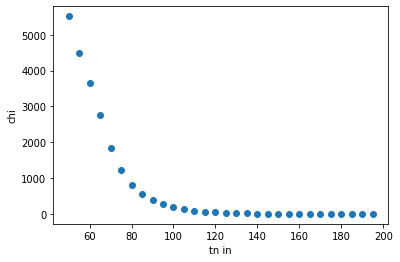

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 28.63710576169813
highHIIIIGHHHHHH:  271.5
rewaRD::  -100
stepping:  2
delta T:  [0.93687004]
curtemp:  69.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65.  65.5 67.  68.5
 69.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.29997575
 33

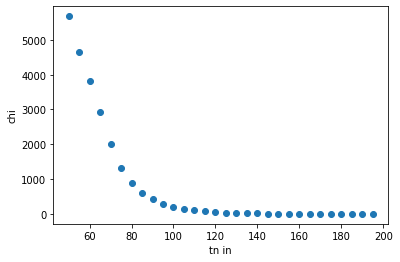

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 26.994390643805406
highHIIIIGHHHHHH:  270.5
rewaRD::  -100
stepping:  2
delta T:  [0.9591506]
curtemp:  70.5
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65.  65.5 67.  68.5
 69.5 70.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.2999757

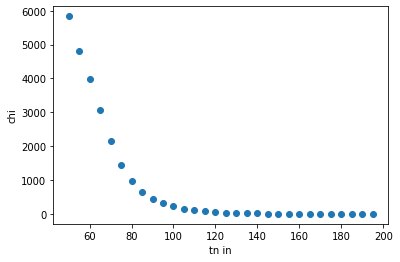

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 25.453094084464873
highHIIIIGHHHHHH:  269.5
rewaRD::  -100
stepping:  2
delta T:  [2.291031]
curtemp:  73.0
Temperature:  [ 3.5  4.   4.5  5.   5.5  6.   7.   7.5  8.   8.5  9.   9.5 10.  10.5
 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  17.  18.  18.5 19.  19.5
 20.  20.5 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.5
 28.  28.5 29.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  35.  35.5 36.5
 37.  38.5 39.5 40.  40.5 41.  41.5 43.  43.5 44.  44.5 45.  45.5 46.
 46.5 47.  48.  48.5 49.  50.  50.5 51.  52.5 53.  55.  56.5 57.  57.5
 58.5 60.  60.5 61.  61.5 62.  63.  63.5 64.  64.5 65.  65.5 67.  68.5
 69.5 70.5 73. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999997 330.29999992
 330.29999982 330.29999962 330.29999923 330.2999912  330.299

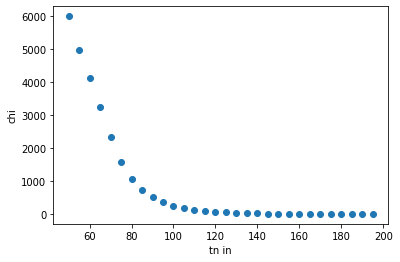

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 23.78226879422998
highHIIIIGHHHHHH:  267.0
rewaRD::  -100
terminated: too long
reset
stepping:  3
delta T:  [1.3527964]
curtemp:  4.5
Temperature:  [4.5]
highHIIIIGHHHHHH:  335.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  5.0
Temperature:  [4.5 5. ]
Intensity:  [330.3 330.3]


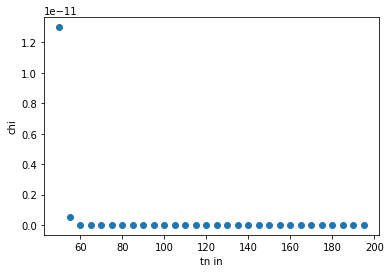

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  335.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  5.5
Temperature:  [4.5 5.  5.5]
Intensity:  [330.3 330.3 330.3]


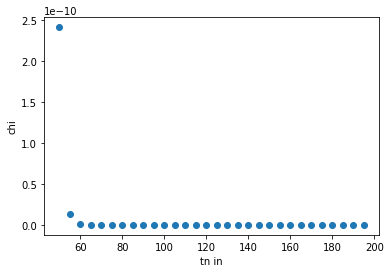

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  334.5
rewaRD::  -100
stepping:  3
delta T:  [1.432024]
curtemp:  7.0
Temperature:  [4.5 5.  5.5 7. ]
Intensity:  [330.3 330.3 330.3 330.3]


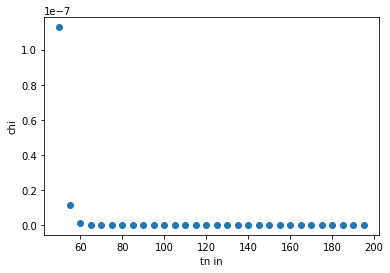

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  333.0
rewaRD::  -100
stepping:  3
delta T:  [2.058079]
curtemp:  9.0
Temperature:  [4.5 5.  5.5 7.  9. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3]


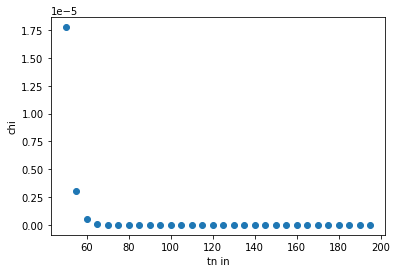

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  331.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  9.5
Temperature:  [4.5 5.  5.5 7.  9.  9.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3]


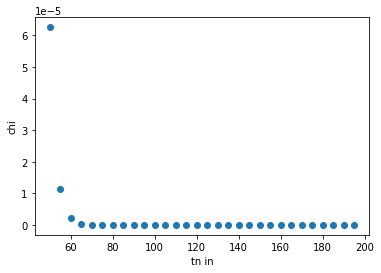

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 99999999.99999999
highHIIIIGHHHHHH:  330.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  10.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3]


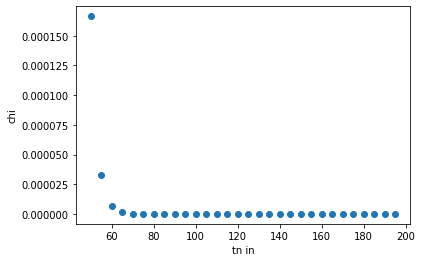

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6234601610961.151
highHIIIIGHHHHHH:  330.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  10.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


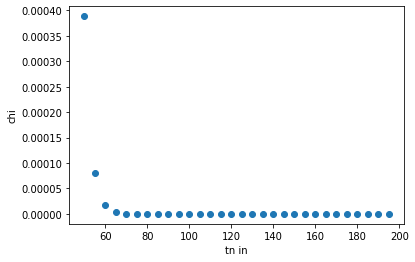

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1222705972067.848
highHIIIIGHHHHHH:  329.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  11.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11. ]
Intensity:  [330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3 330.3]


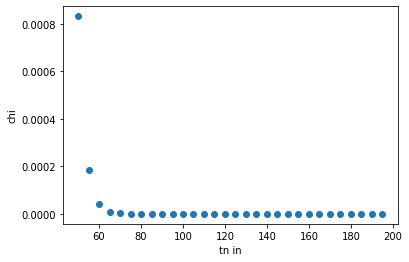

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 276072799603.8155
highHIIIIGHHHHHH:  329.0
rewaRD::  -100
stepping:  3
delta T:  [1.8558973]
curtemp:  13.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997]


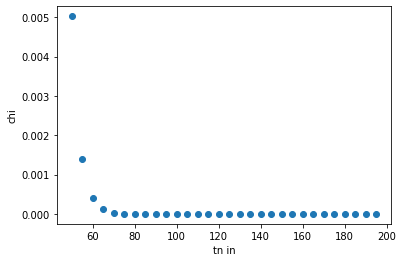

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 4648559074.673836
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  13.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992]


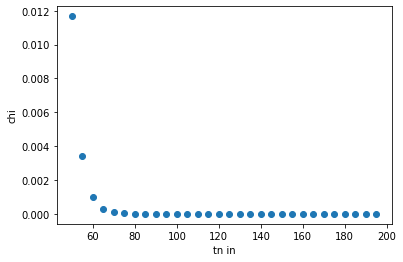

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1832365858.8300226
highHIIIIGHHHHHH:  326.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  14.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982]


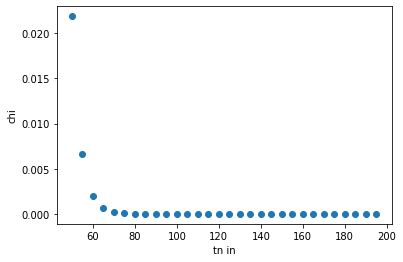

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 814855096.194444
highHIIIIGHHHHHH:  326.0
rewaRD::  -100
stepping:  3
delta T:  [1.0593367]
curtemp:  15.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923]


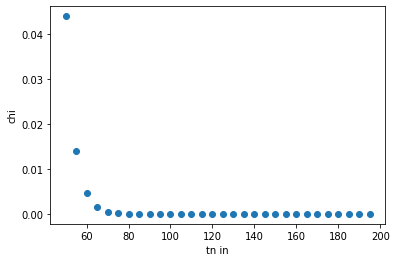

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 214483113.14838088
highHIIIIGHHHHHH:  325.0
rewaRD::  -100
stepping:  3
delta T:  [0.54454345]
curtemp:  15.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985 ]


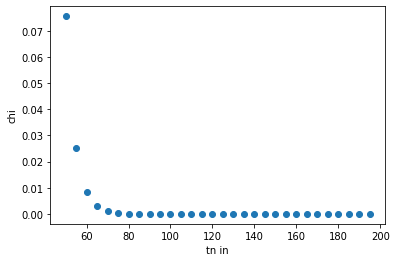

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 103292848.169045
highHIIIIGHHHHHH:  324.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  16.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719]


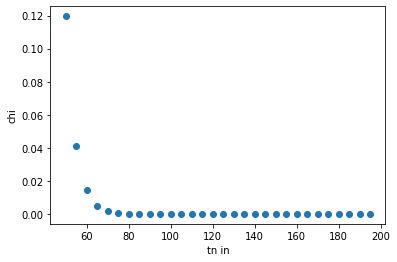

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 55057803.61341977
highHIIIIGHHHHHH:  324.0
rewaRD::  -100
stepping:  3
delta T:  [1.3035865]
curtemp:  17.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518]


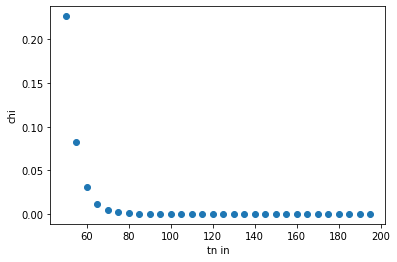

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 13108939.055237975
highHIIIIGHHHHHH:  322.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  18.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575]


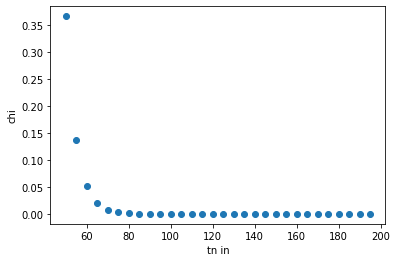

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 7121618.629666487
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
stepping:  3
delta T:  [1.162588]
curtemp:  19.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399 ]


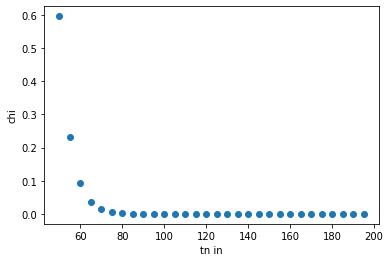

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3222193.217188044
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  19.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864]


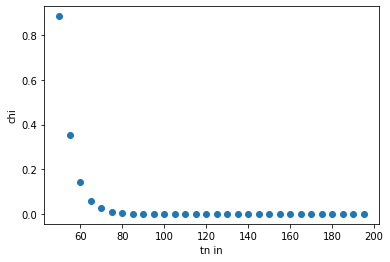

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1944871.0276549256
highHIIIIGHHHHHH:  320.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  20.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864  ]


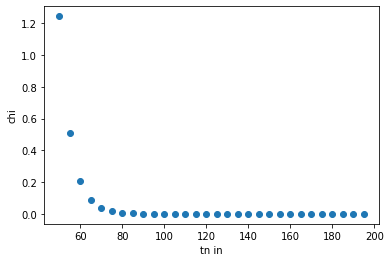

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1271605.78865286
highHIIIIGHHHHHH:  320.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  20.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143]


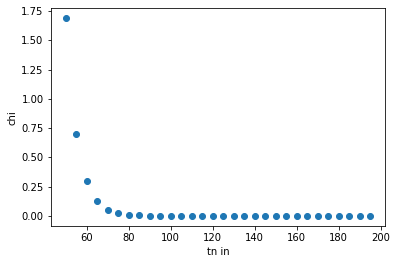

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 864879.624006444
highHIIIIGHHHHHH:  319.5
rewaRD::  -100
stepping:  3
delta T:  [0.8508627]
curtemp:  21.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847]


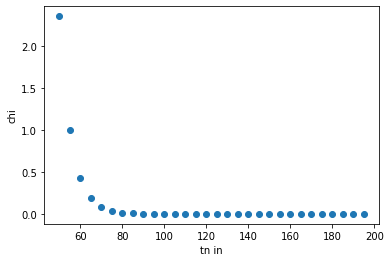

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 499517.0613786963
highHIIIIGHHHHHH:  318.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  22.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256]


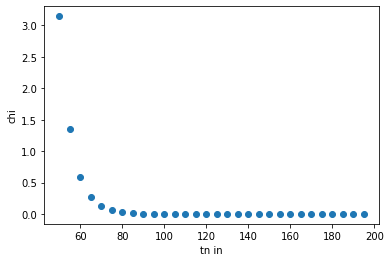

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 334745.7691957455
highHIIIIGHHHHHH:  318.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  22.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733]


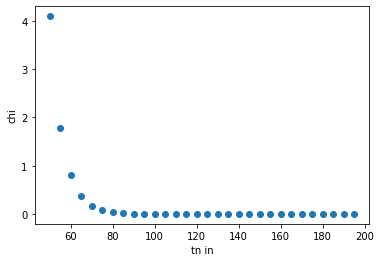

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 237534.80985755063
highHIIIIGHHHHHH:  317.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  23.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065]


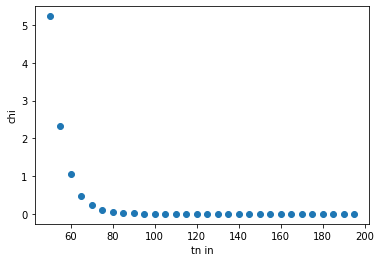

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 173911.56866074042
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  23.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833]


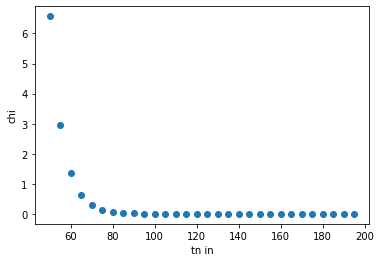

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 130017.0007876095
highHIIIIGHHHHHH:  316.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  24.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391]


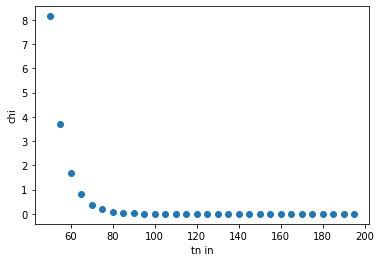

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 98758.03955196422
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
stepping:  3
delta T:  [1.9044689]
curtemp:  26.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624]


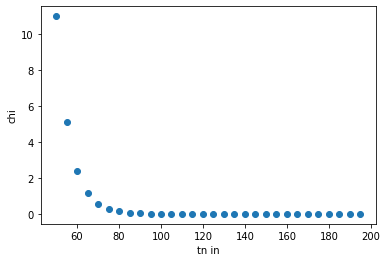

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 51790.33475911858
highHIIIIGHHHHHH:  314.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  26.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253]


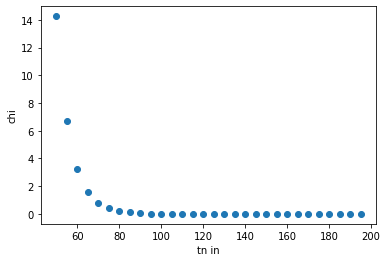

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 35780.57700362101
highHIIIIGHHHHHH:  313.5
rewaRD::  -100
stepping:  3
delta T:  [1.7456082]
curtemp:  28.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428 ]


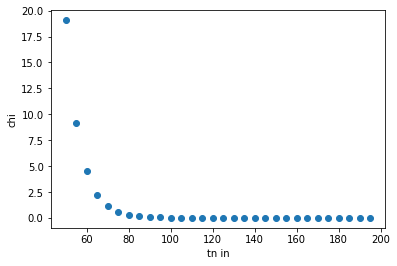

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 22010.490472222406
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  28.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304]


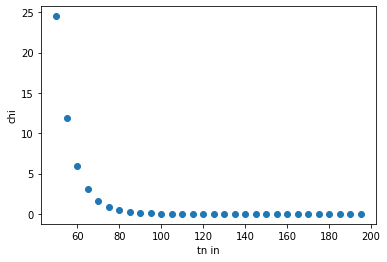

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 16030.110173974213
highHIIIIGHHHHHH:  311.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  29.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806]


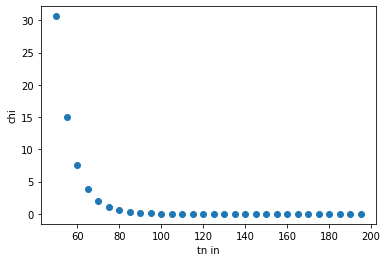

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 12440.490569204934
highHIIIIGHHHHHH:  311.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  29.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757]


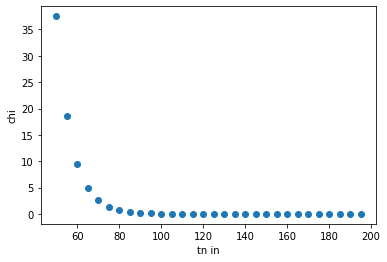

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 9984.254905114845
highHIIIIGHHHHHH:  310.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  30.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789]


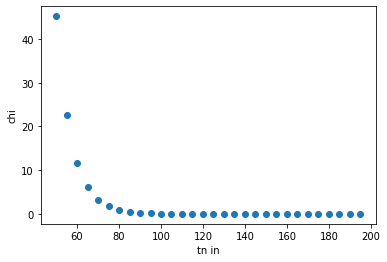

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 8182.73111991971
highHIIIIGHHHHHH:  310.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  30.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192]


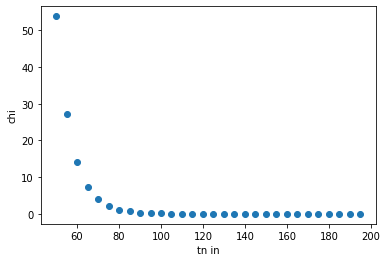

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 6804.729642881183
highHIIIIGHHHHHH:  309.5
rewaRD::  -100
stepping:  3
delta T:  [1.0895364]
curtemp:  31.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263 ]


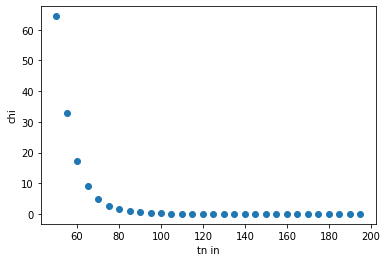

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 5461.994610150233
highHIIIIGHHHHHH:  308.5
rewaRD::  -100
stepping:  3
delta T:  [2.485061]
curtemp:  34.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141]


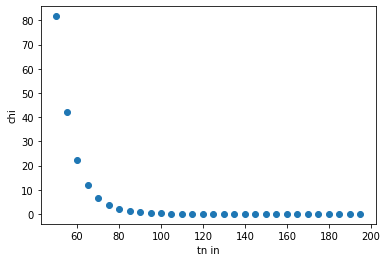

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 3599.070736054948
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  34.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429  ]


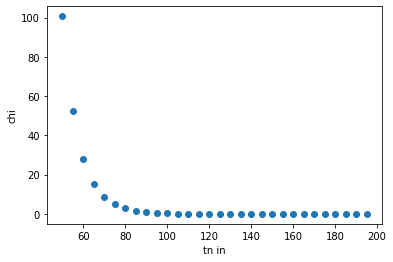

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2747.142518586691
highHIIIIGHHHHHH:  305.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  35.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792]


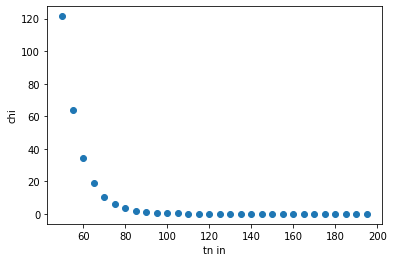

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 2224.7619786888413
highHIIIIGHHHHHH:  305.0
rewaRD::  -100
stepping:  3
delta T:  [0.6733846]
curtemp:  35.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247]


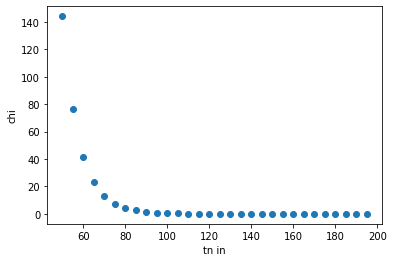

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1860.605765980934
highHIIIIGHHHHHH:  304.5
rewaRD::  -100
stepping:  3
delta T:  [0.5865309]
curtemp:  36.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484]


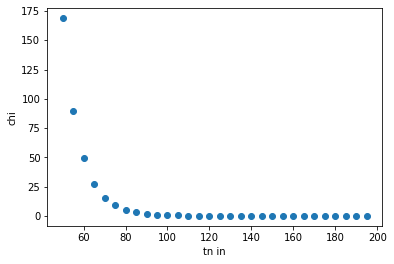

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1587.9398489569128
highHIIIIGHHHHHH:  304.0
rewaRD::  -100
stepping:  3
delta T:  [0.9719108]
curtemp:  37.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423 ]


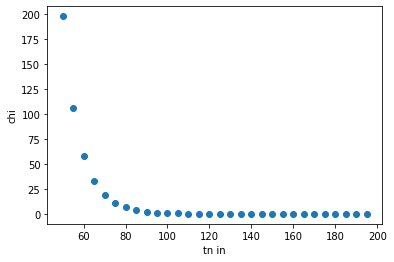

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1337.0648880019125
highHIIIIGHHHHHH:  303.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  37.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276]


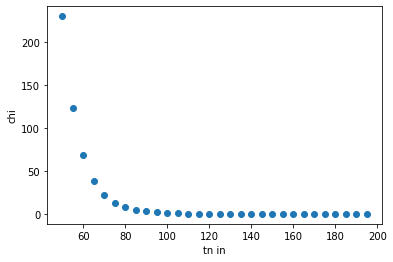

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1148.7816626740666
highHIIIIGHHHHHH:  302.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  38.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08771213]


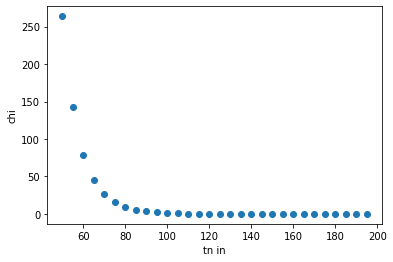

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 1000.9009252254405
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
stepping:  3
delta T:  [0.69888586]
curtemp:  38.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08771213 330.06389463]


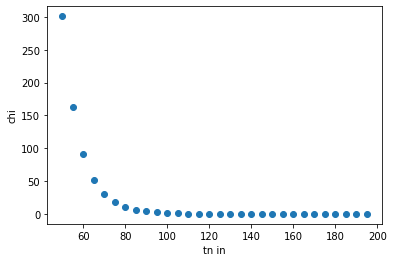

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 881.0935192182907
highHIIIIGHHHHHH:  301.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  39.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08771213 330.06389463
 330.

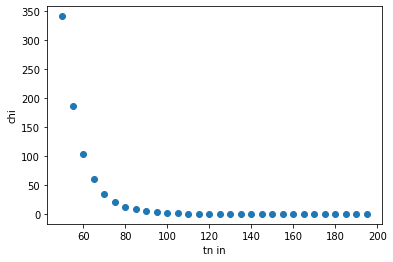

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 781.8404403779349
highHIIIIGHHHHHH:  301.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  39.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08771213 330.06389463


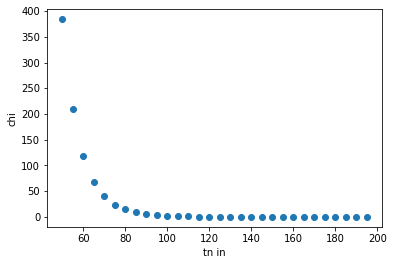

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 698.2308378405228
highHIIIIGHHHHHH:  300.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  40.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08771213 330.0638

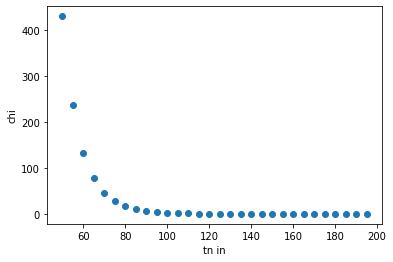

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 626.8840182147746
highHIIIIGHHHHHH:  300.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  40.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40.  40.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08771213 330

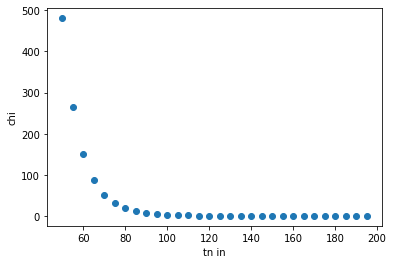

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 565.3739009144389
highHIIIIGHHHHHH:  299.5
rewaRD::  -100
stepping:  3
delta T:  [1.3752989]
curtemp:  42.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40.  40.5 42. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.0

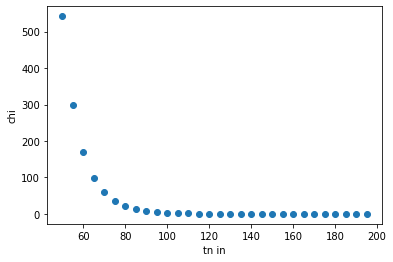

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 495.6046263916876
highHIIIIGHHHHHH:  298.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  42.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40.  40.5 42.  42.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 330.08

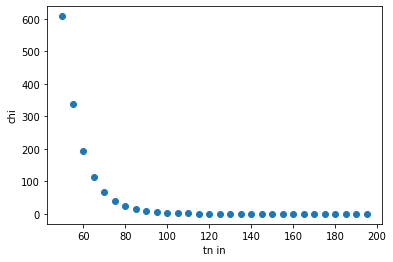

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 439.8513928991957
highHIIIIGHHHHHH:  297.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  43.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40.  40.5 42.  42.5 43. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.10966276 3

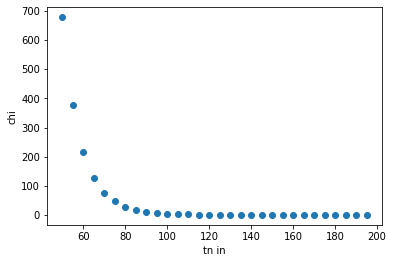

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 394.00366013275635
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  43.5
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40.  40.5 42.  42.5 43.  43.5]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.1096

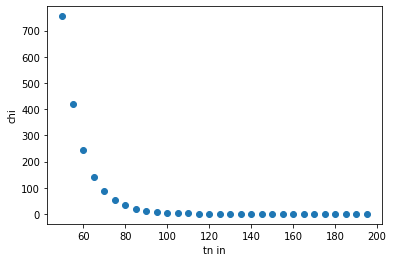

THE RESULT: 195.0
chisqds:  0.0
BUT ARE WE SURE?: 355.4964537747555
highHIIIIGHHHHHH:  296.5
rewaRD::  -100
stepping:  3
delta T:  [0.5]
curtemp:  44.0
Temperature:  [ 4.5  5.   5.5  7.   9.   9.5 10.  10.5 11.  13.  13.5 14.  15.  15.5
 16.  17.5 18.  19.  19.5 20.  20.5 21.5 22.  22.5 23.  23.5 24.  26.
 26.5 28.  28.5 29.  29.5 30.  30.5 31.5 34.  34.5 35.  35.5 36.  37.
 37.5 38.  38.5 39.  39.5 40.  40.5 42.  42.5 43.  43.5 44. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.3        330.3        330.29999997
 330.29999992 330.29999982 330.29999923 330.2999985  330.29999719
 330.29998518 330.29997575 330.2999399  330.29990864 330.299864
 330.29980143 330.29959847 330.29944256 330.29923733 330.29897065
 330.29862833 330.29819391 330.29511624 330.29388253 330.2885428
 330.28608304 330.28320806 330.27986757 330.27600789 330.27157192
 330.2607263  330.21891141 330.207429   330.19471792 330.18069247
 330.16526484 330.1298423  330.

KeyboardInterrupt: ignored

In [ ]:
# Train the agent
model = A2C('MlpPolicy', env, verbose=1).learn(5000)

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

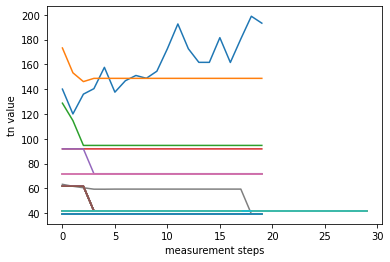

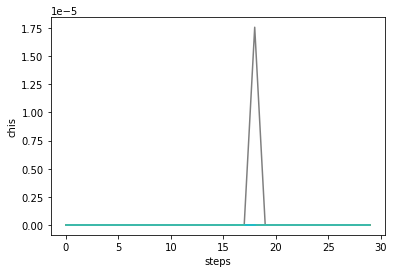

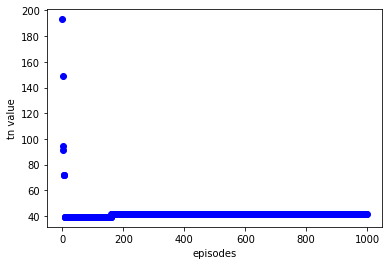

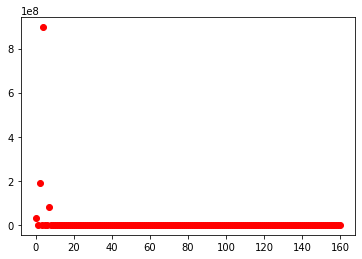

In [ ]:
numTrials = 1000

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
endtns = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
    data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".txt")
    #print(data[i-1])
    chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".txt")

for i in range (0, len(data)): 
    plt.plot(data[i], label = str(i))
    endtns.append(data[i][-1])

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "tns.png")
plt.close()

for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()

plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "endtns.png")
plt.close()

rewards = np.loadtxt('logs/runrewards.txt')
plt.plot(rewards, 'ro')
plt.show()
plt.close()


temperature:  [ 34.  247.5]
Intensity:  [3.29881076e+02 3.00000000e-01]
[15.00007481]


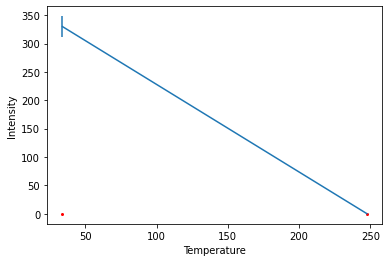

In [ ]:
p=[.885,330,.3]
T=np.arange(50, 300, 4)
T = np.array([34, 247.5])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.show()
plt.savefig("test")
plt.close()